# Predicting Progression Free Survival of TCGA NSCLC Patients: Getting Started

This notebook serves as a getting started template for you to start working on building your awesome model for predicting progression free survival (PFS). We will go through some basic exploratory data analysis (EDA), and build a baseline model that you can modify from. Remember the following timeline:

* 2019-10-27 11:59 PM First checkpoint
* 2019-11-04 11:59 PM Second checkpoint
* 2019-11-11 11:59 PM Final submission

In each checkpoint, you can submit your prediction and get it scored against the test set. The final ranking will be **based on the best score among your up-to-three submissions**. 

## Exploratory data analysis (EDA)

First let's take a look at the data. You can find the challenge data at the following location:

[mini-challenge](https://docs.google.com/presentation/d/1QF9X2lEOQndKUPFYwjFZSITe8ifOnExtjet5Zw88nmI/edit#slide=id.g622cd406a7_0_0)

It should contain the following files:

* `clinical_train`: Clinical information of each patient in the trianing set
* `clinical_test`: Clinical information of each patient in the test set
* `rnaseq_train`: Normalized voom values of RNASeq data of each patient in the trianing set
* `rnaseq_test`: Normalized voom values of RNASeq data of each patient in the test set
* `mut_train`: Mutation information as MAF file format of each patient in the training set
* `mut_test`: Mutation information as MAF file format of each patient in the test set
* `pfs_train`: Progression-free survival of each patient in the training set. **This is your target variables**.

Note there is no `pfs_test` as it is what you are supposed to predict and being scored upon.

In [0]:
from pathlib import Path

# Change this to where you download the files
DATA = Path("data")

### Progression-free survival

The [progression-free survival](https://en.wikipedia.org/wiki/Progression-free_survival) (PFS) measures the amount of time from a starting point (in our case, when the primary tumor sample is taken), to the time when the tumor has progressed (tumor grows or metastasizes). It is a [**right-censored**](https://en.wikipedia.org/wiki/Censoring_(statistics)) data as some of the patients may be out of contact or are still alive at the time the data was generated. 

The PFS info is encoded in two columns: an `event` column indicating whether an event (in this case, progression) has occurred, and also a `time_to_event` column indicating how much time has the subject been under observation. These two columns can be used to perform survival analysis.

In [3]:
import pandas as pd

pfs_train = pd.read_csv(DATA / "pfs_train.txt", sep="\t", index_col="patient_id")
pfs_train.head()

,progression,time_to_progression_or_censor
patient_id,,
TRAIN_0000,1.0,334.0
TRAIN_0001,0.0,1523.0
TRAIN_0002,0.0,121.0
TRAIN_0003,1.0,334.0
TRAIN_0004,1.0,183.0


As part of EDA, we can first construct the overall survival curve using the `lifelines` package.

In [4]:
from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()

kmf.fit(pfs_train.time_to_progression_or_censor, pfs_train.progression)

<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 816 total observations, 525 right-censored observations>

The `KaplanMeierFitter` fit the survival data using the [Kaplan-Meier estimator](https://en.wikipedia.org/wiki/Kaplan%E2%80%93Meier_estimator), or a product-limit estimator, which estimate the survival function at each time point when an event occurrs:

$$
\hat{S}(t) = \prod_{t_i < t}{\frac{n_i - d_i}{n_i}}
$$

where $d_i$ is the number of death events at $t$ and $n_i$ is the number at risk at prior to time $t$.

Once the estimator fits the data, you can plot the survival curve by:

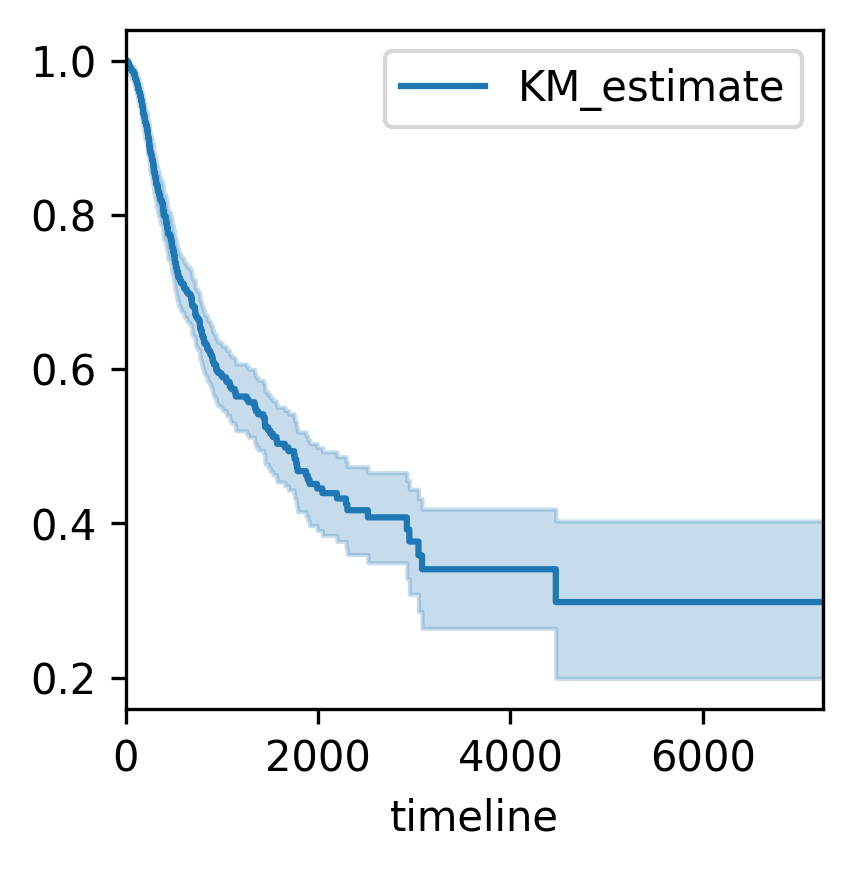

In [5]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(dpi=300, figsize=(3, 3))
kmf.plot(ax=ax)

This plot gives us an overview of the PFS across the population, with the confidence interval. We can also get the median survival of the population by:

In [6]:
print("Median survival time of the population is {}".format(
    kmf.median_survival_time_)
)

Median survival time of the population is 1655.0


### Clinical data

Regarding the features we will be using to predict survival, take a look at the clinical table:

In [7]:
clin_train = pd.read_csv(DATA / "clinical_train.txt", sep="\t", index_col="patient_id")

# also load clin_test
clin_test = pd.read_csv(DATA / "clinical_test.txt", sep="\t", index_col="patient_id")

clin_train.head()

,age_at_initial_pathologic_diagnosis,anatomic_neoplasm_subdivision,diagnosis,eastern_cancer_oncology_group,ethnicity,gender,karnofsky_performance_score,laterality,location_in_lung_parenchyma,number_pack_years_smoked,pathologic_M,pathologic_N,pathologic_T,pathologic_stage,race,radiation_therapy,residual_tumor,tobacco_smoking_history
patient_id,,,,,,,,,,,,,,,,,,
TRAIN_0000,81,L-Upper,Lung Adenocarcinoma,[Not Available],[Not Available],MALE,[Not Available],[Not Available],[Not Available],32,M0,N2,T2,Stage IIIA,[Not Available],[Not Available],R2,4
TRAIN_0001,67,R-Lower,Lung Adenocarcinoma,[Not Available],[Not Available],MALE,[Not Available],[Not Available],Peripheral Lung,52,M0,N0,T2,Stage IB,[Not Available],[Not Available],R0,3
TRAIN_0002,79,R-Lower,Lung Adenocarcinoma,[Not Available],[Not Available],FEMALE,[Not Available],[Not Available],[Not Available],47,M0,N1,T3,Stage IIIA,[Not Available],[Not Available],R2,4
TRAIN_0003,68,L-Upper,Lung Adenocarcinoma,[Not Available],[Not Available],MALE,[Not Available],[Not Available],[Not Available],62,M0,N0,T2,Stage IB,[Not Available],[Not Available],R0,4
TRAIN_0004,66,R-Lower,Lung Adenocarcinoma,[Not Available],[Not Available],MALE,[Not Available],[Not Available],[Not Available],20,M0,N2,T2,Stage IIIA,[Not Available],[Not Available],RX,3


Now with more detailed clinical information, we can see that our data set consists of patients from two main cancer category: `Lung Adenocarcinoma` (LUAD) and `Lung Squamous Cell Carcinoma` (LUSC) (the `diagnosis` column). Let's see if the two tumor types have different PFS profiles.

We can perform a simple uni-variate [Cox Proportional Hazard (PH) model](https://en.wikipedia.org/wiki/Proportional_hazards_model) fitting to compare the survival difference between LUAD and LUSC patient population. The Cox PH model assumes that one-unit change of the feature has a multiplicative effect on the hazard function (effectively the survival function):

$$
\lambda(t|X_i) = \lambda_0(t)\exp(\beta_1 X_1 + \beta_2 X_2 + ... + \beta_p X_p)
$$

The $\lambda_0(.)$ is a baseline hazard function, and will be eliminated when we compare the hazard ratio between two subjects (or populations) with different covariate values ($X_i$'s).

To perform uni-variate Cox PH modeling, we can use the `CoxPHFitter` in the `lifelines` package:

In [8]:
# First construct a data frame with all the variables needed
mat = pd.concat([pfs_train.copy(), clin_train[["diagnosis"]]],
                axis=1, sort=True)
# convert the diagnosis to whether the patient is LUAD
mat["diagnosis"] = mat.diagnosis == "Lung Adenocarcinoma"
mat.rename(columns={"diagnosis": "LUAD"}, inplace=True)

mat.head()

,progression,time_to_progression_or_censor,LUAD
patient_id,,,
TRAIN_0000,1.0,334.0,True
TRAIN_0001,0.0,1523.0,True
TRAIN_0002,0.0,121.0,True
TRAIN_0003,1.0,334.0,True
TRAIN_0004,1.0,183.0,True


In [9]:
from lifelines import CoxPHFitter

cph = CoxPHFitter()
cph.fit(mat, duration_col='time_to_progression_or_censor',
        event_col='progression')

<lifelines.CoxPHFitter: fitted with 816 total observations, 525 right-censored observations>

The `fit` function will fit all the columns other than the two you assigned as `duration_col` and `event_col` to the model. Therefore, be careful what you leave in the data frame.

Once the fitting is done, we can check the `summary` field on the association between your variables and survival.

In [10]:
cph.summary

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,z,p,-log2(p)
LUAD,0.43944,1.551837,0.119613,0.205002,0.673878,1.227527,1.96183,3.673835,0.000239,12.031079


We can see that LUAD has higher hazard (`coef` > 0), which means the LUAD population has shorter average PFS than the LUSC population, with very significant _P_ value. 

Another way to quantify the significance of the association, is to use the [concordance index](https://lifelines.readthedocs.io/en/latest/Survival%20Regression.html#model-selection-based-on-predictive-power), which is also the score we'll be using to evaluate your models. The concordance index compares all _comparable_ pairs of patients in the population, and records the proportion of pairs that has the same order between the predicted values and the survival. See [this article](https://medium.com/analytics-vidhya/concordance-index-72298c11eac7) for detailed information.

The concordance index can be obtained from the `score_` field from a fitted `CoxPHFitter` object. As the `score_` is calculating the concordance with **hazard**, we will need to calculate `1 - score_` to get the concordance index with survival time.

In [11]:
print("The concordance index between tumor type and PFS is {:.4f}".format(
    1 - cph.score_
))

The concordance index between tumor type and PFS is 0.4498


The concordance index is less than 0.5, which means it negatively correlates with _survival time_ (thus positively correlates with _hazard_). The categorical variables generally would have lower concordance index with survival than original numerical variables due to the handling of ties in the calculation.

To visualize this is to plot two separate Kaplan-Meier survival curves for the two populations:

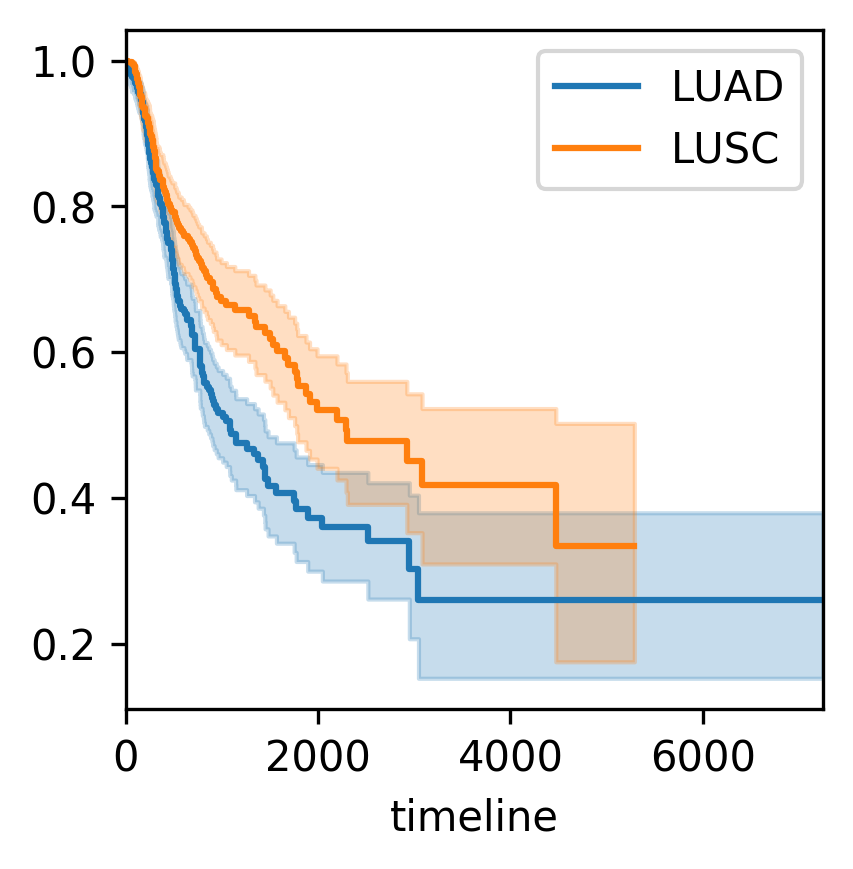

In [12]:
fig, ax = plt.subplots(dpi=300, figsize=(3, 3))

luad_idx = mat.LUAD
kmf.fit(mat.time_to_progression_or_censor[luad_idx], mat.progression[luad_idx],
        label="LUAD")
kmf.plot(ax=ax)
kmf.fit(mat.time_to_progression_or_censor[~luad_idx],
        mat.progression[~luad_idx],
        label="LUSC")
kmf.plot(ax=ax)

The next step is to pre-process the clinical table so it is machine learning ready. To do that, we need to convert the categorical variables into something numerical, one simple way to do that is to use [one-hot encoding](https://medium.com/@michaeldelsole/what-is-one-hot-encoding-and-how-to-do-it-f0ae272f1179). So we will try to identify categorical variables in our data and perform one-hot encoding transformation.

You can see from above that our clinical table is a mixture of continuous variables (_e.g._ `age_at_initial_pathologic_diagnosis`) and categorical variables (_e.g._ `gender`, `diagnosis`). First let's do a simple scan to determine for each column what is its cardinality and if they are categorical, what are their individual values.

In [0]:
def cat_cont_summary_for_col(col: pd.Series, cat_cutoff: int):
    """Given a :class:`pandas.Series`, calculate its cardinality, and if its
    continuous, show summary statistics; if categorical, show unique values
    
    Arguments
    ---------
    col: pandas.Series
        Input series
    cat_cutoff: int
        Cutoff cardinality to determine whether a series is categorical or
        continuous

    Returns
    -------
    col_info: dict
        A dictionary containing info regarding the input series. If the series
    """
    card = col.nunique()
    col_type = "cat" if card <= cat_cutoff else "cont"
    if col_type == "cont":
        col = pd.to_numeric(col, errors="coerce")
    else:
        col = col.astype(str)

    col_info = {
        "cardinality": card,
        "col_type": col_type,
        **col.describe()
    }
    if col_type == "cat":
        col_info["unique_values"] = col.unique()

    return col_info


def cat_cont_summary_for_df(df: pd.DataFrame, cat_cutoff: int = 20):
    """Given a :class:`pandas.DataFrame`, determine whether each column is
    categorical or continuous, and output its summary statistics
    
    Arguments
    ---------
    df: pandas.DataFrame
        Input data frame
    cat_cutoff: int
        Cutoff cardinality to determine whether a series is categorical or
        continuous

    Returns
    -------
    col_summary: pandas.DataFrame
        A :class:`pandas.DataFrame` summarizing the statistics of each column
    """
    col_sums = [cat_cont_summary_for_col(df[col], cat_cutoff)
                for col in df.columns]
    col_summary = pd.DataFrame(col_sums)
    col_summary.index = df.columns.values
    return col_summary

In [14]:
cat_cont_summary_for_df(clin_train)

,cardinality,col_type,count,mean,std,min,25%,50%,75%,max,unique,top,freq,unique_values
age_at_initial_pathologic_diagnosis,53,cont,801.0,66.224719,9.476652,33.00,60.0,67.00,73.0,88.0,NaN,NaN,NaN,NaN
anatomic_neoplasm_subdivision,9,cat,816.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,R-Upper,251.0,"[L-Upper, R-Lower, R-Upper, L-Lower, R-Middle,..."
diagnosis,2,cat,816.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,Lung Adenocarcinoma,413.0,"[Lung Adenocarcinoma, Lung Squamous Cell Carci..."
eastern_cancer_oncology_group,7,cat,816.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0,[Not Available],377.0,"[[Not Available], [Not Evaluated], 1, 0, 3, 2,..."
ethnicity,5,cat,816.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NOT HISPANIC OR LATINO,575.0,"[[Not Available], NOT HISPANIC OR LATINO, HISP..."
gender,2,cat,816.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,MALE,492.0,"[MALE, FEMALE]"
karnofsky_performance_score,13,cat,816.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.0,[Not Available],507.0,"[[Not Available], 0, [Not Evaluated], 80, 90, ..."
laterality,1,cat,816.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,[Not Available],816.0,[[Not Available]]
location_in_lung_parenchyma,4,cat,816.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,[Not Available],358.0,"[[Not Available], Peripheral Lung, Central Lun..."
number_pack_years_smoked,128,cont,622.0,47.547516,28.168011,0.15,28.0,40.25,60.0,180.0,NaN,NaN,NaN,NaN


We can see the determination is not perfect. We can then do some post-processing to fix some issue. 

First we want to convert all the `[Not Available]`, `[Unknown]`, `[Not Evaluable]` to `np.NaN`.

In [0]:
import numpy as np

def replace_by_na(col: pd.Series, char: str = "["):
    idx = [char in str(x) for x in col]
    _col = col.copy()
    _col.loc[idx] = np.NaN
    return _col

# perform the same transformation to both clin_train and clin_test
for col in clin_train.columns:
    clin_train[col] = replace_by_na(clin_train[col])
    clin_test[col] = replace_by_na(clin_test[col])


After this process, we can see the values in brackets are all converted to `np.NaN`

In [16]:
cat_cont_summary_for_df(clin_train)

,cardinality,col_type,count,mean,std,min,25%,50%,75%,max,unique,top,freq,unique_values
age_at_initial_pathologic_diagnosis,52,cont,801.0,66.224719,9.476652,33.00,60.0,67.00,73.0,88.0,NaN,NaN,NaN,NaN
anatomic_neoplasm_subdivision,7,cat,816.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,R-Upper,251.0,"[L-Upper, R-Lower, R-Upper, L-Lower, R-Middle,..."
diagnosis,2,cat,816.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,Lung Adenocarcinoma,413.0,"[Lung Adenocarcinoma, Lung Squamous Cell Carci..."
eastern_cancer_oncology_group,4,cat,816.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,nan,488.0,"[nan, 1, 0, 3, 2]"
ethnicity,2,cat,816.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NOT HISPANIC OR LATINO,575.0,"[nan, NOT HISPANIC OR LATINO, HISPANIC OR LATINO]"
gender,2,cat,816.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,MALE,492.0,"[MALE, FEMALE]"
karnofsky_performance_score,9,cat,816.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,nan,664.0,"[nan, 0, 80, 90, 50, 100, 70, 40, 60, 20]"
laterality,0,cat,816.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,nan,816.0,[nan]
location_in_lung_parenchyma,2,cat,816.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,nan,469.0,"[nan, Peripheral Lung, Central Lung]"
number_pack_years_smoked,127,cont,622.0,47.547516,28.168011,0.15,28.0,40.25,60.0,180.0,NaN,NaN,NaN,NaN


The following code selected a few columns of interests (arbitrarily), convert the categorical variables to [one-hot encoding](https://medium.com/@michaeldelsole/what-is-one-hot-encoding-and-how-to-do-it-f0ae272f1179), then these data frames are machine-learning ready.

In [0]:
cat_cols = ["diagnosis", "location_in_lung_parenchyma", "pathologic_M",
            "pathologic_N", "pathologic_T", "radiation_therapy",
            "residual_tumor"]
cont_cols = ["age_at_initial_pathologic_diagnosis", "number_pack_years_smoked"]

In [0]:
# Concatenate categorical variables of interest and numerical variables of
# interest into ml-ready matrices
x_clin_train = pd.concat([pd.get_dummies(clin_train[cat_cols]),
                          clin_train[cont_cols]], axis=1, sort=True)

x_clin_test = pd.concat([pd.get_dummies(clin_test[cat_cols]),
                         clin_test[cont_cols]], axis=1, sort=True)

In [19]:
pd.get_dummies(clin_train[cat_cols])

,diagnosis_Lung Adenocarcinoma,diagnosis_Lung Squamous Cell Carcinoma,location_in_lung_parenchyma_Central Lung,location_in_lung_parenchyma_Peripheral Lung,pathologic_M_M0,pathologic_M_M1,pathologic_M_M1a,pathologic_M_M1b,pathologic_M_MX,pathologic_N_N0,pathologic_N_N1,pathologic_N_N2,pathologic_N_N3,pathologic_N_NX,pathologic_T_T1,pathologic_T_T1a,pathologic_T_T1b,pathologic_T_T2,pathologic_T_T2a,pathologic_T_T2b,pathologic_T_T3,pathologic_T_T4,pathologic_T_TX,radiation_therapy_NO,radiation_therapy_YES,residual_tumor_R0,residual_tumor_R1,residual_tumor_R2,residual_tumor_RX
patient_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
TRAIN_0000,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
TRAIN_0001,1,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0
TRAIN_0002,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
TRAIN_0003,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0
TRAIN_0004,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TRAIN_0811,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0
TRAIN_0812,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0
TRAIN_0813,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0


### RNASeq data

RNASeq data is very straight-forward. We have ~37,000 gene's expression values, all of them are log2 transformed, continuous values. 

In [20]:
ge_train = pd.read_csv(DATA / "rnaseq_train.txt", sep="\t", index_col=0)
ge_test = pd.read_csv(DATA / "rnaseq_test.txt", sep="\t", index_col=0)

ge_train.head()

,TRAIN_0001,TRAIN_0002,TRAIN_0003,TRAIN_0004,TRAIN_0005,TRAIN_0006,TRAIN_0007,TRAIN_0008,TRAIN_0009,TRAIN_0010,TRAIN_0011,TRAIN_0012,TRAIN_0013,TRAIN_0014,TRAIN_0015,TRAIN_0016,TRAIN_0017,TRAIN_0018,TRAIN_0019,TRAIN_0020,TRAIN_0021,TRAIN_0022,TRAIN_0023,TRAIN_0024,TRAIN_0025,TRAIN_0026,TRAIN_0027,TRAIN_0028,TRAIN_0029,TRAIN_0030,TRAIN_0031,TRAIN_0032,TRAIN_0033,TRAIN_0034,TRAIN_0035,TRAIN_0036,TRAIN_0037,TRAIN_0038,TRAIN_0039,TRAIN_0040,...,TRAIN_0776,TRAIN_0777,TRAIN_0778,TRAIN_0779,TRAIN_0780,TRAIN_0781,TRAIN_0782,TRAIN_0783,TRAIN_0784,TRAIN_0785,TRAIN_0786,TRAIN_0787,TRAIN_0788,TRAIN_0789,TRAIN_0790,TRAIN_0791,TRAIN_0792,TRAIN_0793,TRAIN_0794,TRAIN_0795,TRAIN_0796,TRAIN_0797,TRAIN_0798,TRAIN_0799,TRAIN_0800,TRAIN_0801,TRAIN_0802,TRAIN_0803,TRAIN_0804,TRAIN_0805,TRAIN_0806,TRAIN_0807,TRAIN_0808,TRAIN_0809,TRAIN_0810,TRAIN_0811,TRAIN_0812,TRAIN_0813,TRAIN_0814,TRAIN_0815
A1BG,-1.3364,-1.7668,-1.0198,-0.8983,-5.9363,0.3527,-3.0055,-2.3069,-2.1904,-1.2656,-1.3568,-0.7001,-2.8087,-1.0790,-1.5845,-1.2057,-1.6855,-1.1610,0.4233,-3.0186,-1.7536,-1.3744,-0.7374,-4.0285,-3.9233,-3.0484,-1.3048,-2.3104,-3.3131,-4.6724,-2.4712,-2.6891,-4.0212,-3.2784,-1.4477,-3.3057,-1.9225,-3.4339,-2.0238,-1.0988,...,-1.5283,-1.3231,-0.9713,-0.9121,-0.9251,-1.0919,0.2249,-0.6211,-3.3718,-2.0011,-0.9321,-1.0119,-1.3776,-1.4497,-2.0486,-3.0911,0.6557,0.4914,-0.1059,1.1786,-1.9261,-0.4090,-0.3578,-1.9184,0.4643,0.5011,-3.6151,-2.0062,-1.6154,-1.8095,-0.3868,0.4650,0.6863,-1.3412,-0.3093,-0.5301,-1.9589,-3.5359,-1.4197,-1.5915
A1BG-AS1,1.7801,0.7311,1.3790,1.4652,-1.1814,2.4569,-0.3547,0.1567,-0.4160,0.1432,1.0081,1.3865,0.2076,0.8685,-0.4850,1.6472,1.0725,2.1088,1.9816,-0.6165,-0.1687,1.0956,2.0803,-0.5321,-0.7533,0.3515,0.6253,1.5405,0.9846,-1.1280,0.6834,0.9465,-1.7841,0.5763,1.3927,-1.0927,0.3995,-1.5358,0.9184,2.0496,...,1.1689,0.9989,1.5540,1.3656,1.4299,0.8419,2.1225,1.1096,-0.4218,1.5061,1.0749,1.8351,0.4968,1.0799,0.6248,-0.1076,2.4359,2.0764,2.0007,3.6502,0.1443,2.3077,1.1210,0.4837,2.2172,2.0787,0.0854,0.3697,0.9461,0.9194,1.0042,2.7258,3.2015,1.5483,2.0472,1.6936,-0.0731,-1.6099,0.9022,0.3975
A1CF,-4.3104,-6.9762,-6.0047,-2.7964,1.4124,-6.1761,-7.6493,-1.7065,-4.1164,-6.1236,-5.4997,-5.0364,-6.2681,-2.1363,0.8936,-3.2891,4.6606,-3.7933,-3.4446,3.3810,-5.8411,-4.2620,-4.7193,-6.8359,-5.5082,-6.2184,-4.9292,-5.1178,-6.4830,-6.2573,-6.8635,-5.4965,-3.6586,-5.6003,-6.6572,-5.1801,-6.9669,-6.8933,-5.5681,-6.5907,...,-3.8503,-6.5325,-4.5958,-6.6400,-5.4486,-6.3773,-3.6819,-2.6421,-5.2462,-6.7560,-3.7972,-6.3695,-5.7699,-4.0819,-5.3216,-6.5505,-5.4528,-6.1668,-2.2473,-1.6288,-3.4595,-4.7548,-4.3275,-3.9888,2.9479,-4.2104,-5.9370,-4.8136,-4.9846,-6.5644,-6.1147,-2.3639,-4.3047,-6.6266,-1.3841,-2.4416,-4.8975,-3.7423,-2.3708,-5.0510
A2M,10.2830,9.7800,10.0746,11.1037,10.1339,9.2526,9.9767,10.8297,7.7219,10.6659,8.2200,9.3291,8.6852,9.4124,10.7804,10.0078,9.1490,9.0152,7.9316,8.7049,10.1049,10.1162,7.5333,7.9038,7.5614,7.7608,7.6639,8.8712,7.0693,7.6023,8.2200,8.7249,7.1395,8.7063,8.2883,7.4633,7.1652,7.1328,10.0292,8.1975,...,10.7359,10.1068,9.7267,9.8094,9.0229,6.3728,7.9693,7.1119,6.3637,10.8858,7.7719,6.7333,6.4983,7.5106,7.8337,6.9946,7.7285,8.4274,9.0582,9.8243,9.1790,9.2028,11.1617,10.0291,10.1678,7.7649,6.6188,6.4436,8.4880,7.7960,5.2123,10.2018,8.2129,8.3069,7.2597,7.9215,7.8997,9.5837,11.1142,9.2260
A2M-AS1,-0.4035,-0.7095,1.2080,-0.2786,-0.3216,-0.6842,-0.4894,-0.6612,1.3232,0.0663,-0.2903,0.2490,0.1413,0.0721,-1.3330,-0.5834,0.8852,0.1136,0.1161,-0.4684,-1.3175,1.4217,-0.1464,0.4215,0.6279,0.7474,-0.0713,1.8011,-0.0736,0.1177,0.8712,1.4693,0.5024,-0.9954,-0.9292,0.6012,0.8973,0.2462,0.3467,-1.2331,...,-0.0878,0.2619,0.5058,0.4580,0.1856,1.3709,0.4428,1.3093,-0.9486,0.8513,1.2220,0.4507,0.7999,0.6074,0.4772,0.6879,-0.3513,-0.1444,-0.9085,-1.1982,-0.3238,0.0353,0.0649,0.1971,0.4249,-1.4879,-0.2091,-1.1131,0.2249,1.2494,0.7054,-0.3080,-0.9542,-1.6724,0.6538,-0.1474,0.6365,0.3054,-0.3004,-0.6586


The only issue is given such huge dimension, the model is almost bound to [overfitting](https://en.wikipedia.org/wiki/Overfitting). Therefore it is critical to perform some feature selection before we give it to the model. One simple way to do feature selection is to take only the top genes with highest correlation with survival and build model on top of them.

So we will pick the top 100 genes with highest concordance (or anti-concordance) with PFS and extract them to build the model.

We will use the `lifelines.utils.concordance_index` function so we don't need to fit the full Cox model.

In [0]:
mat = pd.concat([pfs_train, ge_train.transpose()], axis=1, sort=True).dropna()

In [22]:
from tqdm import tqdm
from lifelines.utils import concordance_index

out = []

# calculate concordance index for all genes, THIS WILL TAKE A WHILE
for i in tqdm(range(2, mat.shape[1]), total=mat.shape[1] - 2):
    out.append((mat.columns[i],
                concordance_index(mat.time_to_progression_or_censor,
                                  mat.iloc[:, i],
                                  mat.progression)))

100%|██████████| 36926/36926 [06:53<00:00, 89.38it/s]


In [23]:
cidx_df = pd.DataFrame(out)
cidx_df.columns = ["gene", "cidx"]
cidx_df["dev_from_random"] = (cidx_df.cidx - 0.5).abs()
cidx_df.sort_values("dev_from_random", ascending=False, inplace=True)
cidx_df.head()

,gene,cidx,dev_from_random
29893,SESN3,0.614928,0.114928
32863,TESK2,0.606131,0.106131
19872,NTRK2,0.604501,0.104501
30749,SMARCA1,0.397744,0.102256
8276,FMO4,0.601611,0.101611


In [0]:
top_genes = cidx_df.iloc[:100].gene.values

We'll just use these top genes to feed to our models. If you want to further improve, you can also try to **combine co-expressed genes into gene set** to reduce co-linearity.

In [0]:
x_ge_train = ge_train.loc[top_genes].transpose()
x_ge_test = ge_test.loc[top_genes].transpose()

### Mutation data

Finally let's take a look at mutation data. The mutation data has the same format of MAF files. Here we'll aggregate the `MODERATE` and `HIGH` impact mutations by genes and pivot it into a matrix.

In [26]:
mut_train = pd.read_csv(DATA / "mut_train.txt", sep="\t")
mut_test = pd.read_csv(DATA / "mut_test.txt", sep="\t")

mut_train.head()

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (56,70,77) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,AA_MAF,AFR_MAF,ALLELE_NUM,AMR_MAF,ASN_MAF,Allele,Amino_acids,BAM_File,BIOTYPE,CANONICAL,CCDS,CDS_position,CLIN_SIG,CONTEXT,COSMIC,Center,Chromosome,Codons,Consequence,DISTANCE,DOMAINS,EAS_MAF,EA_MAF,ENSP,EUR_MAF,EXON,End_Position,Entrez_Gene_Id,ExAC_AF,ExAC_AF_AFR,ExAC_AF_AMR,ExAC_AF_Adj,ExAC_AF_EAS,ExAC_AF_FIN,ExAC_AF_NFE,ExAC_AF_OTH,ExAC_AF_SAS,Existing_variation,Exon_Number,FILTER,...,RefSeq,Reference_Allele,SAS_MAF,SIFT,SOMATIC,SWISSPROT,SYMBOL,SYMBOL_SOURCE,Score,Sequence_Source,Sequencer,Sequencing_Phase,Start_Position,Strand,TRANSCRIPT_STRAND,TREMBL,TSL,Transcript_ID,Tumor_Seq_Allele1,Tumor_Seq_Allele2,Tumor_Validation_Allele1,Tumor_Validation_Allele2,UNIPARC,VARIANT_CLASS,Validation_Method,Validation_Status,Variant_Classification,Variant_Type,Verification_Status,all_effects,cDNA_position,dbSNP_RS,dbSNP_Val_Status,n_alt_count,n_depth,n_ref_count,t_alt_count,t_depth,t_ref_count,patient_id
0,NaN,NaN,1,NaN,NaN,A,NaN,NaN,protein_coding,YES,CCDS37.1,-/1779,NaN,CAGAAGCTAAG,NaN,BI,chr1,NaN,intron_variant,NaN,NaN,NaN,NaN,ENSP00000367830,NaN,NaN,2156152,5590,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PASS,...,NM_002744.4,G,NaN,NaN,NaN,Q05513,PRKCZ,HGNC,NaN,NaN,Illumina HiSeq 2000,NaN,2156152,+,1.0,NaN,1.0,ENST00000378567,G,A,NaN,NaN,UPI0000169EB7,SNV,NaN,NaN,Intron,SNP,NaN,"PRKCZ,intron_variant,,ENST00000378567,NM_00274...",-/2326,novel,NaN,NaN,24,NaN,4,12,8,TRAIN_0693
1,NaN,NaN,1,NaN,NaN,A,F/L,NaN,protein_coding,YES,CCDS122.1,678/1245,NaN,CCATTCAGGGC,NaN,BI,chr1,ttC/ttA,missense_variant,NaN,Pfam_domain:PF00076;PROSITE_profiles:PS50102;S...,NaN,NaN,ENSP00000240185,NaN,5/6,11020563,23435,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5/6,PASS,...,NM_007375.3,C,NaN,deleterious(0),NaN,Q13148,TARDBP,HGNC,NaN,NaN,Illumina HiSeq 2000,NaN,11020563,+,1.0,A0A024R4E2,1.0,ENST00000240185,C,A,NaN,NaN,UPI0000136B42,SNV,NaN,NaN,Missense_Mutation,SNP,NaN,"TARDBP,missense_variant,p.F226L,ENST0000024018...",1034/5367,novel,NaN,NaN,136,NaN,36,126,90,TRAIN_0693
2,NaN,NaN,1,NaN,NaN,T,S/I,NaN,protein_coding,YES,CCDS30694.2,4157/10128,NaN,GATCAGTCGTC,NaN,BI,chr1,aGt/aTt,missense_variant,NaN,NaN,NaN,NaN,ENSP00000457168,NaN,29/71,43430030,23334,0.000008,0.0,0.0,0.000008,0.0,0.0,0.000015,0.0,0.0,rs765781424,29/71,PASS,...,NM_015284.3,G,NaN,tolerated(0.36),NaN,Q5T011,SZT2,HGNC,NaN,NaN,Illumina HiSeq 2000,NaN,43430030,+,1.0,NaN,5.0,ENST00000562955,G,T,NaN,NaN,UPI0001E24F46,SNV,NaN,NaN,Missense_Mutation,SNP,NaN,"SZT2,missense_variant,p.S1386I,ENST00000562955...",4157/12281,rs765781424,NaN,NaN,160,NaN,43,179,136,TRAIN_0693
3,NaN,NaN,1,NaN,NaN,C,H,NaN,protein_coding,YES,CCDS504.1,1287/1470,NaN,GATCATGGAAG,NaN,BI,chr1,caT/caC,synonymous_variant,NaN,TIGRFAM_domain:TIGR00272,NaN,NaN,ENSP00000255108,NaN,5/6,43972276,1802,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5/6,PASS,...,NM_001384.4,T,NaN,NaN,NaN,Q9BQC3,DPH2,HGNC,NaN,NaN,Illumina HiSeq 2000,NaN,43972276,+,1.0,NaN,1.0,ENST00000255108,T,C,NaN,NaN,UPI0000070CCB,SNV,NaN,NaN,Silent,SNP,NaN,"DPH2,synonymous_variant,p.H429H,ENST0000025510...",1459/2472,novel,NaN,NaN,94,NaN,31,107,76,TRAIN_0693
4,NaN,0.0,1,0.0,NaN,T,NaN,NaN,protein_coding,YES,CCDS551.1,-/1467,NaN,TTTTTAAAAAA,NaN,BI,chr1,NaN,3_prime_UTR_variant,NaN,NaN,0.002,NaN,ENSP00000360913,0.0,13/13,48298627,54558,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs527462674,13/13,PASS,...,NM_019073.3,A,0.0,NaN,NaN,Q9NWH7,SPATA6,HGNC,NaN,NaN,Illumina HiSeq 2000,NaN,48298627,+,-1.0,NaN,2.0,ENST00000371847,A,T,NaN,NaN,UPI0000049C41,SNV,NaN,NaN,3'UTR,SNP,NaN,"SPATA6,3_prime_UTR_variant,,ENST00000371847,NM...",1718/4973,rs527462674,by1000G;byFrequency,NaN,31,NaN,4,39,35,TRAIN_0693


One thing we need to take note is that not all patients have mutation data. However, it is safe to assume that all patients that have mutation data would have at least one mutation in the mutation file. For patients who don't have mutation data, we will need to put in `np.NaN` in their entries, while for patients who have mutation data but did not show mutations in a certain gene, we will need to fill in no-mutations in those entries (0's). 

Therefore, we need to first keep record of the patients who exist in the mutation files, and fill in their entries differently. 

In [0]:
mut_pts_train = set(mut_train.patient_id)
mut_pts_test = set(mut_test.patient_id)

Now let's pivot the mutation data:

In [28]:

mut_train.head()

,AA_MAF,AFR_MAF,ALLELE_NUM,AMR_MAF,ASN_MAF,Allele,Amino_acids,BAM_File,BIOTYPE,CANONICAL,CCDS,CDS_position,CLIN_SIG,CONTEXT,COSMIC,Center,Chromosome,Codons,Consequence,DISTANCE,DOMAINS,EAS_MAF,EA_MAF,ENSP,EUR_MAF,EXON,End_Position,Entrez_Gene_Id,ExAC_AF,ExAC_AF_AFR,ExAC_AF_AMR,ExAC_AF_Adj,ExAC_AF_EAS,ExAC_AF_FIN,ExAC_AF_NFE,ExAC_AF_OTH,ExAC_AF_SAS,Existing_variation,Exon_Number,FILTER,...,RefSeq,Reference_Allele,SAS_MAF,SIFT,SOMATIC,SWISSPROT,SYMBOL,SYMBOL_SOURCE,Score,Sequence_Source,Sequencer,Sequencing_Phase,Start_Position,Strand,TRANSCRIPT_STRAND,TREMBL,TSL,Transcript_ID,Tumor_Seq_Allele1,Tumor_Seq_Allele2,Tumor_Validation_Allele1,Tumor_Validation_Allele2,UNIPARC,VARIANT_CLASS,Validation_Method,Validation_Status,Variant_Classification,Variant_Type,Verification_Status,all_effects,cDNA_position,dbSNP_RS,dbSNP_Val_Status,n_alt_count,n_depth,n_ref_count,t_alt_count,t_depth,t_ref_count,patient_id
0,NaN,NaN,1,NaN,NaN,A,NaN,NaN,protein_coding,YES,CCDS37.1,-/1779,NaN,CAGAAGCTAAG,NaN,BI,chr1,NaN,intron_variant,NaN,NaN,NaN,NaN,ENSP00000367830,NaN,NaN,2156152,5590,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PASS,...,NM_002744.4,G,NaN,NaN,NaN,Q05513,PRKCZ,HGNC,NaN,NaN,Illumina HiSeq 2000,NaN,2156152,+,1.0,NaN,1.0,ENST00000378567,G,A,NaN,NaN,UPI0000169EB7,SNV,NaN,NaN,Intron,SNP,NaN,"PRKCZ,intron_variant,,ENST00000378567,NM_00274...",-/2326,novel,NaN,NaN,24,NaN,4,12,8,TRAIN_0693
1,NaN,NaN,1,NaN,NaN,A,F/L,NaN,protein_coding,YES,CCDS122.1,678/1245,NaN,CCATTCAGGGC,NaN,BI,chr1,ttC/ttA,missense_variant,NaN,Pfam_domain:PF00076;PROSITE_profiles:PS50102;S...,NaN,NaN,ENSP00000240185,NaN,5/6,11020563,23435,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5/6,PASS,...,NM_007375.3,C,NaN,deleterious(0),NaN,Q13148,TARDBP,HGNC,NaN,NaN,Illumina HiSeq 2000,NaN,11020563,+,1.0,A0A024R4E2,1.0,ENST00000240185,C,A,NaN,NaN,UPI0000136B42,SNV,NaN,NaN,Missense_Mutation,SNP,NaN,"TARDBP,missense_variant,p.F226L,ENST0000024018...",1034/5367,novel,NaN,NaN,136,NaN,36,126,90,TRAIN_0693
2,NaN,NaN,1,NaN,NaN,T,S/I,NaN,protein_coding,YES,CCDS30694.2,4157/10128,NaN,GATCAGTCGTC,NaN,BI,chr1,aGt/aTt,missense_variant,NaN,NaN,NaN,NaN,ENSP00000457168,NaN,29/71,43430030,23334,0.000008,0.0,0.0,0.000008,0.0,0.0,0.000015,0.0,0.0,rs765781424,29/71,PASS,...,NM_015284.3,G,NaN,tolerated(0.36),NaN,Q5T011,SZT2,HGNC,NaN,NaN,Illumina HiSeq 2000,NaN,43430030,+,1.0,NaN,5.0,ENST00000562955,G,T,NaN,NaN,UPI0001E24F46,SNV,NaN,NaN,Missense_Mutation,SNP,NaN,"SZT2,missense_variant,p.S1386I,ENST00000562955...",4157/12281,rs765781424,NaN,NaN,160,NaN,43,179,136,TRAIN_0693
3,NaN,NaN,1,NaN,NaN,C,H,NaN,protein_coding,YES,CCDS504.1,1287/1470,NaN,GATCATGGAAG,NaN,BI,chr1,caT/caC,synonymous_variant,NaN,TIGRFAM_domain:TIGR00272,NaN,NaN,ENSP00000255108,NaN,5/6,43972276,1802,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5/6,PASS,...,NM_001384.4,T,NaN,NaN,NaN,Q9BQC3,DPH2,HGNC,NaN,NaN,Illumina HiSeq 2000,NaN,43972276,+,1.0,NaN,1.0,ENST00000255108,T,C,NaN,NaN,UPI0000070CCB,SNV,NaN,NaN,Silent,SNP,NaN,"DPH2,synonymous_variant,p.H429H,ENST0000025510...",1459/2472,novel,NaN,NaN,94,NaN,31,107,76,TRAIN_0693
4,NaN,0.0,1,0.0,NaN,T,NaN,NaN,protein_coding,YES,CCDS551.1,-/1467,NaN,TTTTTAAAAAA,NaN,BI,chr1,NaN,3_prime_UTR_variant,NaN,NaN,0.002,NaN,ENSP00000360913,0.0,13/13,48298627,54558,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs527462674,13/13,PASS,...,NM_019073.3,A,0.0,NaN,NaN,Q9NWH7,SPATA6,HGNC,NaN,NaN,Illumina HiSeq 2000,NaN,48298627,+,-1.0,NaN,2.0,ENST00000371847,A,T,NaN,NaN,UPI0000049C41,SNV,NaN,NaN,3'UTR,SNP,NaN,"SPATA6,3_prime_UTR_variant,,ENST00000371847,NM...",1718/4973,rs527462674,by1000G;byFrequency,NaN,31,NaN,4,39,35,TRAIN_0693


In [0]:
x_mut_train = mut_train[
    (mut_train.IMPACT.isin({"MODERATE", "HIGH"})) & (mut_train.FILTER == "PASS")
].pivot_table(index="patient_id", columns="Hugo_Symbol", values="t_alt_count")
# convert the values to 1 if there is a mutation, else fill in 0
x_mut_train[x_mut_train > 0] = 1
x_mut_train.fillna(0, inplace=True)

x_mut_test = mut_test[
    (mut_test.IMPACT.isin({"MODERATE", "HIGH"})) & (mut_test.FILTER == "PASS")
].pivot_table(index="patient_id", columns="Hugo_Symbol", values="t_alt_count")
# convert the values to 1 if there is a mutation, else fill in 0
x_mut_test[x_mut_test > 0] = 1
x_mut_test.fillna(0, inplace=True)

In [30]:
x_mut_train.head()

Hugo_Symbol,A1BG,A1CF,A2M,A2ML1,A3GALT2,A4GALT,A4GNT,AAAS,AACS,AADAC,AADACL2,AADACL3,AADACL4,AADAT,AAED1,AAGAB,AAK1,AAMP,AANAT,AAR2,AARD,AARS,AARS2,AASDH,AASDHPPT,AASS,AATF,AATK,ABAT,ABCA1,ABCA10,ABCA12,ABCA13,ABCA2,ABCA3,ABCA4,ABCA5,ABCA6,ABCA7,ABCA8,...,ZRSR2,ZSCAN1,ZSCAN10,ZSCAN12,ZSCAN16,ZSCAN18,ZSCAN2,ZSCAN20,ZSCAN21,ZSCAN22,ZSCAN23,ZSCAN25,ZSCAN26,ZSCAN29,ZSCAN30,ZSCAN31,ZSCAN32,ZSCAN4,ZSCAN5A,ZSCAN5B,ZSCAN9,ZSWIM1,ZSWIM2,ZSWIM3,ZSWIM4,ZSWIM5,ZSWIM6,ZSWIM8,ZUFSP,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1,ZZZ3,pk
patient_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
TRAIN_0001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TRAIN_0002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
TRAIN_0003,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TRAIN_0004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TRAIN_0005,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


This is a lot of features (17586), we will just keep the top 100 most frequently mutated genes. Note these 100 genes do not contain several important oncogenes including `EGFR`, `KRAS`, and `BRAF`. This can be something you consider add to your model and see if it works.

In [0]:
mut_freq = x_mut_train.sum(axis=0).sort_values(ascending=False)
top_mut_genes = mut_freq.index.values[:100]

In [0]:
x_mut_train = x_mut_train[top_mut_genes]
x_mut_test = x_mut_test[top_mut_genes]

### Combine different modalities

After pre-processing, we now can finally put clinical, RNASeq and mutation information all together, and create a training and testing matrices for our machine learning models.

In [0]:
# to prevent duplicated gene names from mutation matrix and ge matrix, we add
# suffix of `_mut` to all the genes in mut table

x_mut_train.columns = [x + "_mut" for x in x_mut_train.columns]
x_mut_test.columns = [x + "_mut" for x in x_mut_test.columns]

x_train = pd.concat([x_clin_train, x_ge_train, x_mut_train], axis=1, sort=True)
x_test = pd.concat([x_clin_test, x_ge_test, x_mut_test], axis=1, sort=True)

In [34]:
x_train.head()

,diagnosis_Lung Adenocarcinoma,diagnosis_Lung Squamous Cell Carcinoma,location_in_lung_parenchyma_Central Lung,location_in_lung_parenchyma_Peripheral Lung,pathologic_M_M0,pathologic_M_M1,pathologic_M_M1a,pathologic_M_M1b,pathologic_M_MX,pathologic_N_N0,pathologic_N_N1,pathologic_N_N2,pathologic_N_N3,pathologic_N_NX,pathologic_T_T1,pathologic_T_T1a,pathologic_T_T1b,pathologic_T_T2,pathologic_T_T2a,pathologic_T_T2b,pathologic_T_T3,pathologic_T_T4,pathologic_T_TX,radiation_therapy_NO,radiation_therapy_YES,residual_tumor_R0,residual_tumor_R1,residual_tumor_R2,residual_tumor_RX,age_at_initial_pathologic_diagnosis,number_pack_years_smoked,SESN3,TESK2,NTRK2,SMARCA1,FMO4,FGFR2,HLF,KRT42P,RGMA,...,DNAH7_mut,CPS1_mut,ANKRD30A_mut,RP1L1_mut,PXDNL_mut,SSPO_mut,CTNNA2_mut,BRINP3_mut,FAT1_mut,DNAH11_mut,OBSCN_mut,MYH1_mut,SPHKAP_mut,HERC2_mut,NF1_mut,SORCS1_mut,COL12A1_mut,NEB_mut,ASPM_mut,NPAP1_mut,MYH2_mut,ASTN1_mut,FBN2_mut,TENM1_mut,CACNA1E_mut,MRC1_mut,AHNAK_mut,SYNE2_mut,THSD7B_mut,FMN2_mut,VCAN_mut,CRB1_mut,PCDH10_mut,TNN_mut,DNAH3_mut,CDH12_mut,AHNAK2_mut,COL6A3_mut,MUC5B_mut,NALCN_mut
TRAIN_0000,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,81,32,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TRAIN_0001,1,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,67,52,7.6986,2.7103,1.1814,4.8155,2.5635,4.7445,5.8091,-1.7602,3.6904,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
TRAIN_0002,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,79,47,5.7339,1.9924,-0.4684,6.6989,1.6926,2.4437,6.1519,-4.1689,0.9721,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TRAIN_0003,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,68,62,4.6815,3.0889,-0.6472,5.5111,1.8261,5.1153,1.6026,-2.9458,4.3729,...,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0
TRAIN_0004,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,66,20,5.6656,2.4480,3.5271,7.1710,2.3102,3.9597,3.7342,-3.0859,1.8263,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Before we can fit it to the model, one thing we need to take care of is the missing values. Here we will use a simple median impute to all the missing values, which means we fill in the median of the column for all the missing values in each column. There are other imputation methods you can look into, such as the ones in the [`fancyimpute`](https://github.com/iskandr/fancyimpute) package, or random-forest-based method in [`impyte`](https://github.com/andirs/impyte). 

In [0]:
# simple median value impute
from sklearn.impute import SimpleImputer

imp_mean = SimpleImputer(missing_values=np.nan, strategy='median')
x_train_imp = pd.DataFrame(imp_mean.fit_transform(x_train),
                           index=x_train.index, columns=x_train.columns)
x_test_imp = pd.DataFrame(imp_mean.fit_transform(x_test),
                          index=x_test.index, columns=x_test.columns)

In order to make sure the prediction works, we first need to make sure that both train and test matrices have the same columns. Let's just use the overlapping columns to construct training and testing matrix.

In [0]:
# Use only common columns of the training and test set
common_columns = set(x_train_imp.columns) & set(x_test_imp.columns)
x_train_imp = x_train_imp[list(common_columns)]
x_test_imp = x_test_imp[list(common_columns)]

In [37]:
x_train_imp.head()

,ZNF804B_mut,RELN_mut,ST6GALNAC2,RGMA,COL22A1_mut,DNAH11_mut,COL6A3_mut,ANK2_mut,ASTE1,PCDH11X_mut,APOB_mut,GRHL3,SORCS1_mut,RP1L1_mut,SUSD4,PNMA1,NAV3_mut,NTF4,PXDNL_mut,PCDHA5,SPTA1_mut,CYB5R2,residual_tumor_R0,UGGT2,CSTA,PTPRZ1,ASPM_mut,SYNE2_mut,PCDH15_mut,FAT3_mut,pathologic_M_M1,MIR205HG,RHOF,CERS3-AS1,pathologic_T_T2b,PVR,TUBB3,PKHD1_mut,GOLM1,CDH10_mut,...,SYNPR-AS1,ADAMTS12_mut,DNAH7_mut,number_pack_years_smoked,SLC52A1,MUC16_mut,CD9,FAM83A-AS1,AHNAK2_mut,pathologic_N_N2,diagnosis_Lung Squamous Cell Carcinoma,TP53I3,FBXO4,STARD5,NKILA,TNR_mut,SI_mut,ERICH3_mut,TESK2,COL12A1_mut,VCAN_mut,RYR1_mut,pathologic_T_T2,SESN3,WNT2B,OBSCN_mut,pathologic_N_N0,HMCN1_mut,FBN2_mut,FMN2_mut,AKAP12,CSMD1_mut,DNAH9_mut,pathologic_T_T4,HCN1_mut,NALCN_mut,PLEKHG2,LRP10,FAM222B,ADGRV1_mut
TRAIN_0000,0.0,0.0,4.8112,3.7736,0.0,0.0,0.0,0.0,3.2012,0.0,0.0,2.5667,0.0,0.0,4.2817,5.0514,0.0,1.4961,0.0,-2.6337,0.0,3.7086,0.0,4.1685,4.0247,4.0948,0.0,0.0,0.0,0.0,0.0,3.6491,1.7323,-3.7191,0.0,5.4583,2.0568,0.0,7.0482,0.0,...,-0.9309,0.0,0.0,32.0,1.8029,0.0,8.9196,0.6107,0.0,1.0,0.0,4.7750,3.6161,1.8844,1.4224,0.0,0.0,0.0,2.8074,0.0,0.0,0.0,1.0,6.3960,2.2016,0.0,0.0,0.0,0.0,0.0,4.3474,0.0,0.0,0.0,0.0,0.0,5.2812,7.8831,5.1987,0.0
TRAIN_0001,0.0,1.0,2.6685,3.6904,0.0,0.0,0.0,0.0,3.0230,0.0,1.0,1.9402,0.0,1.0,4.2708,4.4611,0.0,0.0012,0.0,-2.2598,1.0,3.6195,1.0,4.3585,1.8393,-1.3899,0.0,0.0,0.0,1.0,0.0,1.2354,1.4330,-7.1178,0.0,5.2532,3.7533,0.0,9.3852,0.0,...,0.1583,1.0,0.0,52.0,1.7981,1.0,7.3454,2.0294,0.0,0.0,0.0,3.9191,3.0205,1.6537,0.3821,1.0,0.0,0.0,2.7103,1.0,0.0,0.0,1.0,7.6986,2.7167,1.0,1.0,1.0,0.0,0.0,3.2496,0.0,0.0,0.0,0.0,1.0,4.8163,8.2852,6.0084,0.0
TRAIN_0002,1.0,0.0,5.0664,0.9721,0.0,0.0,0.0,0.0,3.2320,0.0,0.0,1.1987,0.0,1.0,1.1582,6.1302,0.0,0.6748,0.0,-3.2758,1.0,2.8230,0.0,4.1211,2.2012,1.8279,0.0,0.0,1.0,0.0,0.0,3.3378,3.4677,-5.3913,0.0,7.7549,5.2529,0.0,8.3084,0.0,...,-0.7864,1.0,0.0,47.0,0.6458,1.0,7.8213,3.0336,0.0,0.0,0.0,6.2048,3.7961,0.6311,4.2520,0.0,0.0,0.0,1.9924,0.0,0.0,0.0,0.0,5.7339,0.1218,1.0,0.0,0.0,1.0,0.0,4.8696,1.0,0.0,0.0,0.0,0.0,6.8538,8.4670,6.4135,0.0
TRAIN_0003,0.0,1.0,3.5024,4.3729,1.0,1.0,1.0,1.0,3.3492,1.0,1.0,1.6748,1.0,1.0,3.9730,6.0168,1.0,1.3847,1.0,2.2605,1.0,3.6240,1.0,5.3453,2.5201,3.4040,1.0,1.0,1.0,1.0,0.0,-0.2588,2.8972,-7.5897,0.0,6.3064,3.1064,1.0,8.9082,1.0,...,-7.5897,1.0,0.0,62.0,2.8355,1.0,9.4865,0.0898,0.0,0.0,0.0,4.5887,3.2233,1.8133,0.6911,0.0,1.0,1.0,3.0889,1.0,1.0,0.0,1.0,4.6815,1.9630,1.0,1.0,1.0,0.0,1.0,4.2841,0.0,1.0,0.0,0.0,1.0,5.0616,8.1029,5.7760,0.0
TRAIN_0004,0.0,0.0,3.6037,1.8263,0.0,0.0,0.0,0.0,3.1386,0.0,0.0,2.9511,0.0,0.0,4.4350,4.3244,1.0,1.0203,0.0,-1.8636,0.0,3.0318,0.0,3.7734,1.9968,-0.8296,0.0,0.0,0.0,1.0,0.0,-3.9339,2.9705,-4.6709,0.0,5.1751,3.3272,0.0,6.8181,0.0,...,0.9240,0.0,0.0,20.0,-0.8296,0.0,8.8594,0.8837,0.0,1.0,0.0,5.8293,3.2618,0.8422,2.1148,0.0,0.0,0.0,2.4480,0.0,0.0,0.0,1.0,5.6656,2.4480,0.0,0.0,0.0,0.0,1.0,4.7049,0.0,0.0,0.0,0.0,0.0,6.7112,8.3404,5.4407,0.0


Now we are ready to trian our models!

## XGBoost model

The gradient boosting model (GBM) has been widely used in multiple data science challenges for its high performance and built-in feature selection and importance ranking. The [`XGBoost`](https://xgboost.ai/) implementation also contains several convenient functions for parameter tuning, cross validation _etc_.

Here we will build an XGBoost model using the training matrix we constructed. Note the XGBoost model actually can deal with missing values as is (it will treat it as an additional category), also it can actually deal with large feature space as well. You may try to see if you don't do any feature selection in preprocessing, or keep missing values as np.NaN, whether the model would perform better.

To use XGBoost model to predict survival, you will need to use the `survival:cox` objective.

In [0]:
import xgboost as xgb

In [0]:
# convert the censored time in PFS to negative
# Since XGBoost only allow one column for y, the censoring information
# is coded as negative values:

y_train = (np.where(pfs_train.progression == 1, 1, -1) *
           pfs_train.time_to_progression_or_censor)
dtrain = xgb.DMatrix(x_train_imp, label=y_train.values)

There are several parameter we can set to the `xgboost` model. Below are a few you might find yourself using a lot:
* `learning_rate`: this is the learning rate. The smaller the value, the more trees you need to fit the data better.
* `subsample`: set this number between 0 and 1 and when the model build each tree it will only use a subset of the sample. This can prevent overfitting but will require more trees to fit.
* `colsample_bytree`: similar to `subsample`, but take subset in feature space.
* `max_depth`: The maximum depth of each tree. The higher the depth you fit the data better in the expense of higher chance of overfitting. Depending on how many variables you think might interact with each other, usually a low number (`< 10`) should be enough.
* `objective`: the type of distribution of your target value. In our case we use `survival:cox` for cox regression.
* `n_estimator`: the maximum number of trees you fit. 
* `early_stopping_rounds`: if the model does not improve for this number of rounds, the training will stop. This is useful to make sure the model fits well.

See [xgboost documentation](https://xgboost.readthedocs.io/en/latest/python/index.html) for details.

One way to estimate what set of parameters to use, is to perform cross validations on each set of parameters, and pick the best parameter set to train on the full set. The following we will try three different sets of parameters, and for each one performs 5-fold cross validation to estimate which set might lead to better performance.

In [0]:
xgb_params = [
{
    "eta": 0.01,
    "subsample": 0.5,
    "colsample_bytree": 0.75,
    "max_depth": 5,
    "objective": "survival:cox",
    "eval_metric": "cox-nloglik",
    "seed": 4060
},
{
    "eta": 0.01,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "max_depth": 10,
    "objective": "survival:cox",
    "eval_metric": "cox-nloglik",
    "seed": 4060
}, 
{
    "eta": 0.01,
    "subsample": 0.5,
    "colsample_bytree": 0.5,
    "max_depth": 5,
    "objective": "survival:cox",
    "eval_metric": "cox-nloglik",
    "seed": 4060
}]

The first parameter set is a balance setting between fitting depth and regularization, while the second one tries to fit the data for each tree as much as possible (if not over-fit), and the third one tries to under-fit for each tree and see if ensembl of weak learners can lead to better generalizations.

In [0]:
cv_scores = []
cv_rounds = []
for params in xgb_params:
    cvout = xgb.cv(params, dtrain, num_boost_round=1000, nfold=5,
                   early_stopping_rounds=10)
    # get the best (minimum) loss score
    cv_scores.append(cvout["test-cox-nloglik-mean"].min())
    cv_rounds.append(cvout["test-cox-nloglik-mean"].idxmin())

In [42]:
cv_scores

[4.2497968, 4.258532000000001, 4.2345822]

In [43]:
cv_rounds

[86, 96, 146]

We see the first parameter set has slightly better performance. We will use this parameter set to fit the full data and generate prediction.

In [0]:
xgbmodel = xgb.train(xgb_params[np.argmin(cv_scores)],
                     dtrain, num_boost_round=cv_rounds[np.argmin(cv_scores)])

Once the model is fit, we can generate predictions on our test set.

In [45]:
dtest = xgb.DMatrix(x_test_imp)
pred = xgbmodel.predict(dtest)
print(pred[:10])

[0.5579317  0.9284827  0.91190773 0.4127163  0.36586434 1.3416202
 0.6814749  1.0784726  0.48456833 0.9106068 ]


We see the model generates continuous risk scores for each patient. This will be your prediction scores. In order to submit your prediction, you will need to construct a data frame with `patient_id` and `risk_score`. 

In [46]:
pred_df = pd.DataFrame({
    "patient_id": x_test_imp.index.values,
    "risk_score": pred
})

pred_df.head()

,patient_id,risk_score
0,TEST_0000,0.557932
1,TEST_0001,0.928483
2,TEST_0002,0.911908
3,TEST_0003,0.412716
4,TEST_0004,0.365864


To submit, you will save the data frame as a `csv` file in the `submission` Google drive folder (https://drive.google.com/open?id=1bdW_Z7K2zlUSGWl4LbGIoPSn8EjNR3pt), using your UNI as the file name.

The following is the official scoring function that check the validity of your submission and give the concordance index.

In [0]:
def score_submission(df, pfs_test):
    if "patient_id" not in df.columns:
        raise ValueError(
            "Input data frame does not contain 'patient_id' column!"
        )
    
    if "risk_score" not in df.columns:
        raise ValueError(
            "Input data frame does not contain 'risk_score' column!"
        )

    df_ = df.merge(pfs_test, how="right")
    if not np.all(df_.risk_score.notnull()):
        raise ValueError(
            "Input data frame does not has risk scores for all patients!"
        )
    
    from lifelines.utils import concordance_index
    return concordance_index(df_.time_to_progression_or_censor,
                             df_.risk_score, df_.progression)

Let's see it in action. Note you will not have access to the `pfs_test.txt` file. But you can hold out your own test set to see if it's working in your pipeline.

In [0]:
pfs_test = pd.read_csv("/content/drive/My Drive/2019 ECBM E4060/mini-challenge/data/pfs_test.txt",
                       sep="\t")

In [0]:
#pred_df.to_csv(DATA / "../submission/wc2302_baseline.csv")

In [50]:
score_submission(pred_df, pfs_test)

0.41649454116258483

## Blend: DeepSuv, Random Survival Forest, Xgboost

In [51]:
!pip install pysurvival

#### Random Survival Forest

In [135]:
from pysurvival.models.survival_forest import RandomSurvivalForestModel
from pysurvival.utils.metrics import concordance_index
from pysurvival.utils.display import integrated_brier_score

# Building training and testing sets #
index_train, index_test = train_test_split(range(x_train.shape[0]), test_size = 0.2)
data_train = x_train_imp.iloc[index_train].reset_index( drop = True )
data_test  = x_train_imp.iloc[index_test].reset_index( drop = True )

X_train, X_test = data_train, data_test
T_train, T_test = pfs_train.iloc[index_train].time_to_progression_or_censor.values, pfs_train.iloc[index_test].time_to_progression_or_censor.values
E_train, E_test = pfs_train.iloc[index_train].progression.values, pfs_train.iloc[index_test].progression.values
structure = [ {'activation': 'SELU', 'num_units': 150},  ]
rsf = RandomSurvivalForestModel(num_trees=100)
                              
rsf.fit(X_train, T_train, E_train,
        max_features='sqrt', max_depth=6, min_node_size=10, sample_size_pct=0.7)

#### 5 - Cross Validation / Model Performances
c_index = concordance_index(rsf, X_test, T_test, E_test) #0.81
print('C-index: {:.2f}'.format(c_index))

C-index: 0.64


In [137]:
rsf = RandomSurvivalForestModel(num_trees=100)
                              
rsf.fit(x_train_imp,  pfs_train.time_to_progression_or_censor.values, pfs_train.progression.values,
        max_features="sqrt", max_depth=9, min_node_size=10, sample_size_pct=0.5)

pred_rsf = rsf.predict_risk(x_test_imp)
pred_rsf_df = pd.DataFrame({
    "patient_id": x_test_imp.index.values,
    "risk_score": pred_rsf
})

score_submission(pred_rsf_df, pfs_test)

0.43257598111537326

In [60]:
max_depth = [1,2,3,4,5,6,7,8,9,10]
score = []
for x in max_depth:
  rsf = RandomSurvivalForestModel(num_trees=100)
                              
  rsf.fit(x_train_imp,  pfs_train.time_to_progression_or_censor.values, pfs_train.progression.values,
        max_features="sqrt", max_depth=x, min_node_size=10, sample_size_pct=0.7)

  pred_rsf = rsf.predict_risk(x_test_imp)
  pred_rsf_df = pd.DataFrame({
    "patient_id": x_test_imp.index.values,
    "risk_score": pred_rsf
  })
  s = score_submission(pred_rsf_df, pfs_test)
  print(x, s)
  score.append(s)

1 0.424609029212157
2 0.43611684862791383
3 0.43257598111537326
4 0.42652699911478315
5 0.4285925051637651
6 0.43596931248155796
7 0.42977279433461196
8 0.4352316317497787
9 0.4216583062850398
10 0.4331661257007967


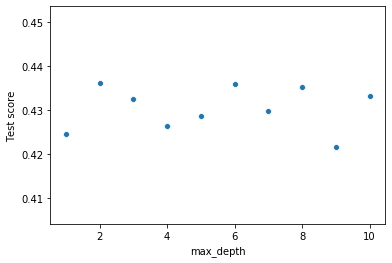

In [61]:
sns.scatterplot(x=max_depth, y=score)
plt.xlabel('max_depth')
plt.ylabel('Test score');

In [70]:
sample_size = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
score_sample = []
for x in sample_size:
  rsf = RandomSurvivalForestModel(num_trees=100)
                              
  rsf.fit(x_train_imp,  pfs_train.time_to_progression_or_censor.values, pfs_train.progression.values,
        max_features="sqrt", max_depth=9, min_node_size=10, sample_size_pct=x)
  pred_rsf = rsf.predict_risk(x_test_imp)
  pred_rsf_df = pd.DataFrame({
    "patient_id": x_test_imp.index.values,
    "risk_score": pred_rsf
  })
  s = score_submission(pred_rsf_df, pfs_test)
  print(x, s)
  score_sample.append(s)

0.1 0.4229861316022426
0.2 0.42637946296842727
0.3 0.4300678666273237
0.4 0.4476246680436707
0.5 0.41944526408970195
0.6 0.441133077604013
0.7 0.428740041310121
0.8 0.4305104750663913
0.9 0.4336087341398643
1.0 0.4231336677485984


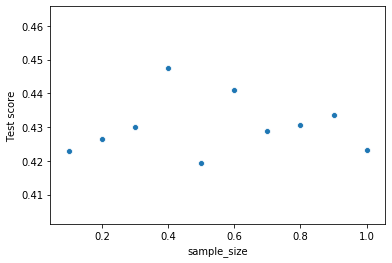

In [71]:
sns.scatterplot(x=sample_size, y=score_sample)
plt.xlabel('sample_size')
plt.ylabel('Test score');

In [72]:
num_tree = [10, 50, 100, 150, 200 ,250, 300, 400, 500]
score_tree = []
for x in num_tree:
  rsf = RandomSurvivalForestModel(num_trees=x)
                              
  rsf.fit(x_train_imp,  pfs_train.time_to_progression_or_censor.values, pfs_train.progression.values,
        max_features="sqrt", max_depth=9, min_node_size=10, sample_size_pct=0.5)
  pred_rsf = rsf.predict_risk(x_test_imp)
  pred_rsf_df = pd.DataFrame({
    "patient_id": x_test_imp.index.values,
    "risk_score": pred_rsf
  })
  s = score_submission(pred_rsf_df, pfs_test)
  print(x, s)
  score_tree.append(s)

10 0.43995278843316615
50 0.42785482443198586
100 0.43434641487164355
150 0.43095308350545886
200 0.43714960165240485
250 0.4406904691649454
300 0.4336087341398643


KeyboardInterrupt: ignored

In [0]:
sns.scatterplot(x=num_tree, y=score_tree)
plt.xlabel('num_tree')
plt.ylabel('Test score');

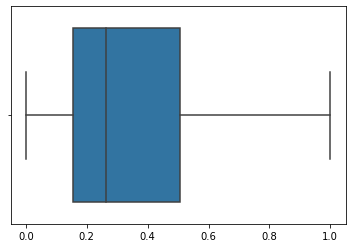

In [66]:
from sklearn import preprocessing
rf = preprocessing.minmax_scale(pred_rsf_df.risk_score.values,feature_range=(0,1))
sns.boxplot(rf)

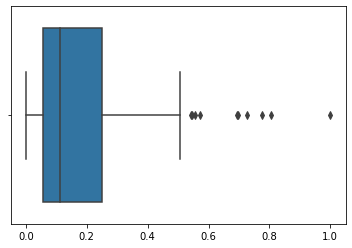

In [67]:
from sklearn import preprocessing
xg = preprocessing.minmax_scale(pred_df.risk_score.values,feature_range=(0,1))
sns.boxplot(xg)

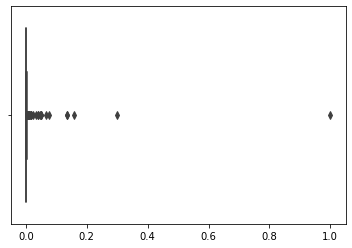

In [68]:
dv = preprocessing.minmax_scale(pred_deepsuv_df.risk_score.values,feature_range=(0,1))
sns.boxplot(dv)

In [69]:
pred_blend_df = pd.DataFrame({
    "patient_id": x_test_imp.index.values,
    "risk_score": [0.3*x+0.3*y+0.4*z for x,y,z in zip(rf,ds,xg)]
})
pred_blend_df.head()

NameError: ignored

In [0]:
sns.boxplot(pred_blend_df.risk_score.values)

In [0]:
pred_blend_df.to_csv('jg4159_blend.csv')

### Reduce co-linearity

#### 0. check correlation among x_clin_train

In [0]:
def generate_xgb_model(xtrain, xtest, pfstrain = pfs_train):
    xgb_params =[
    {
    "eta": 0.01,
    "subsample": 0.6,
    "colsample_bytree": 0.6,
    "max_depth": 6,
    "objective": "survival:cox",
    "eval_metric": "cox-nloglik",
    "seed": 4060
    },
    {
    "eta": 0.01,
    "subsample": 0.6,
    "colsample_bytree": 0.6,
    #"colsample_bylevel": 0.6,
    "max_depth": 5,
    "objective": "survival:cox",
    "eval_metric": "cox-nloglik",
    "seed": 4060
    },
    {
    "eta": 0.01,
    "subsample": 0.75,
    "colsample_bytree": 0.75,
    #"colsample_bylevel": 0.75,
    "max_depth": 6,
    "objective": "survival:cox",
    "eval_metric": "cox-nloglik",
    "seed": 4060
    }]

    imp_mean = SimpleImputer(missing_values=np.nan, strategy='median')
    xtrain = pd.DataFrame(imp_mean.fit_transform(xtrain),
                           index=xtrain.index, columns=xtrain.columns)
    xtest = pd.DataFrame(imp_mean.fit_transform(xtest),
                          index=xtest.index, columns=xtest.columns)
    # Use only common columns of the training and test set
    common_columns = set(xtrain.columns) & set(xtest.columns)
    xtrain = xtrain[list(common_columns)]
    xtest = xtest[list(common_columns)]
    y_train = (np.where(pfstrain.progression == 1, 1, -1) *
           pfstrain.time_to_progression_or_censor)
    dtrain = xgb.DMatrix(xtrain, label=y_train.values) # check label
    cv_scores = [] # score on test set after each round  
    cv_rounds = [] # number of rounds to get to best test score
    for params in xgb_params:
        cvout = xgb.cv(params, dtrain, num_boost_round=1000, nfold=5, # 5-fold cross validation
                early_stopping_rounds=10)
        # get the best (minimum) loss score
        cv_scores.append(cvout["test-cox-nloglik-mean"].min())
        cv_rounds.append(cvout["test-cox-nloglik-mean"].idxmin())
    # generate model
    xgbmodel = xgb.train(xgb_params[np.argmin(cv_scores)],
                     dtrain, num_boost_round=cv_rounds[np.argmin(cv_scores)])
    # make prediction
    my_dtest = xgb.DMatrix(xtest) #mytest split from x_train_imp contains the features for my test set
    my_pred = xgbmodel.predict(my_dtest)
    my_pred_df = pd.DataFrame({
          "patient_id": xtest.index.values,
          "risk_score": my_pred
    })
    print("cv_score:", np.amin(cv_scores))
    return my_pred_df

In [0]:
import seaborn as sns
def corr_heatmap(df,annotation=True,size=(6,6)):
     # Plot figsize
    fig, ax = plt.subplots(figsize=size)
    corr = df.corr()
    ax = sns.heatmap(
      corr, annot=annotation, fmt=".2f",
      vmin=-1, vmax=1, center=0,
      cmap=sns.diverging_palette(220, 20, n=200),
      square=True
    )
    ax.set_xticklabels(
      ax.get_xticklabels(),
      rotation=45,
      horizontalalignment='right'
    )
    ax.set_title("correlation heatmap");


In [0]:
corr_heatmap(x_clin_train, size=(20,20))

In [81]:
x_train = pd.concat([x_clin_train, x_ge_train, x_mut_train], axis=1, sort=True)
x_test = pd.concat([x_clin_test, x_ge_test, x_mut_test], axis=1, sort=True)
score_submission(generate_xgb_model(x_train, x_test), pfs_test)

cv_score: 4.250547600000001


0.43729713779876067

####1. Remove unknown values

In [0]:
import numpy as np
# remove 'MX','NX','TX','RX'
def replace_by_na(col: pd.Series):
    idx = [x in ['[Not Available]', '[Not Evaluated]', '[Unknown]', '[Discrepancy]','MX','NX','TX','RX'] for x in col]
    _col = col.copy()
    _col.loc[idx] = np.NaN
    return _col

# perform the same transformation to both clin_train and clin_test
for col in clin_train.columns:
    clin_train[col] = replace_by_na(clin_train[col])
    clin_test[col] = replace_by_na(clin_test[col])

cat_cols = ["diagnosis", "pathologic_M", "radiation_therapy", "pathologic_N", "pathologic_stage", "pathologic_T", "residual_tumor"]
cont_cols = ["age_at_initial_pathologic_diagnosis", "number_pack_years_smoked"]

# Concatenate categorical variables of interest and numerical variables of
# interest into ml-ready matrices
x_clin_train = pd.concat([pd.get_dummies(clin_train[cat_cols]),
                          clin_train[cont_cols]], axis=1, sort=True)
x_clin_test = pd.concat([pd.get_dummies(clin_test[cat_cols]),
                         clin_test[cont_cols]], axis=1, sort=True)

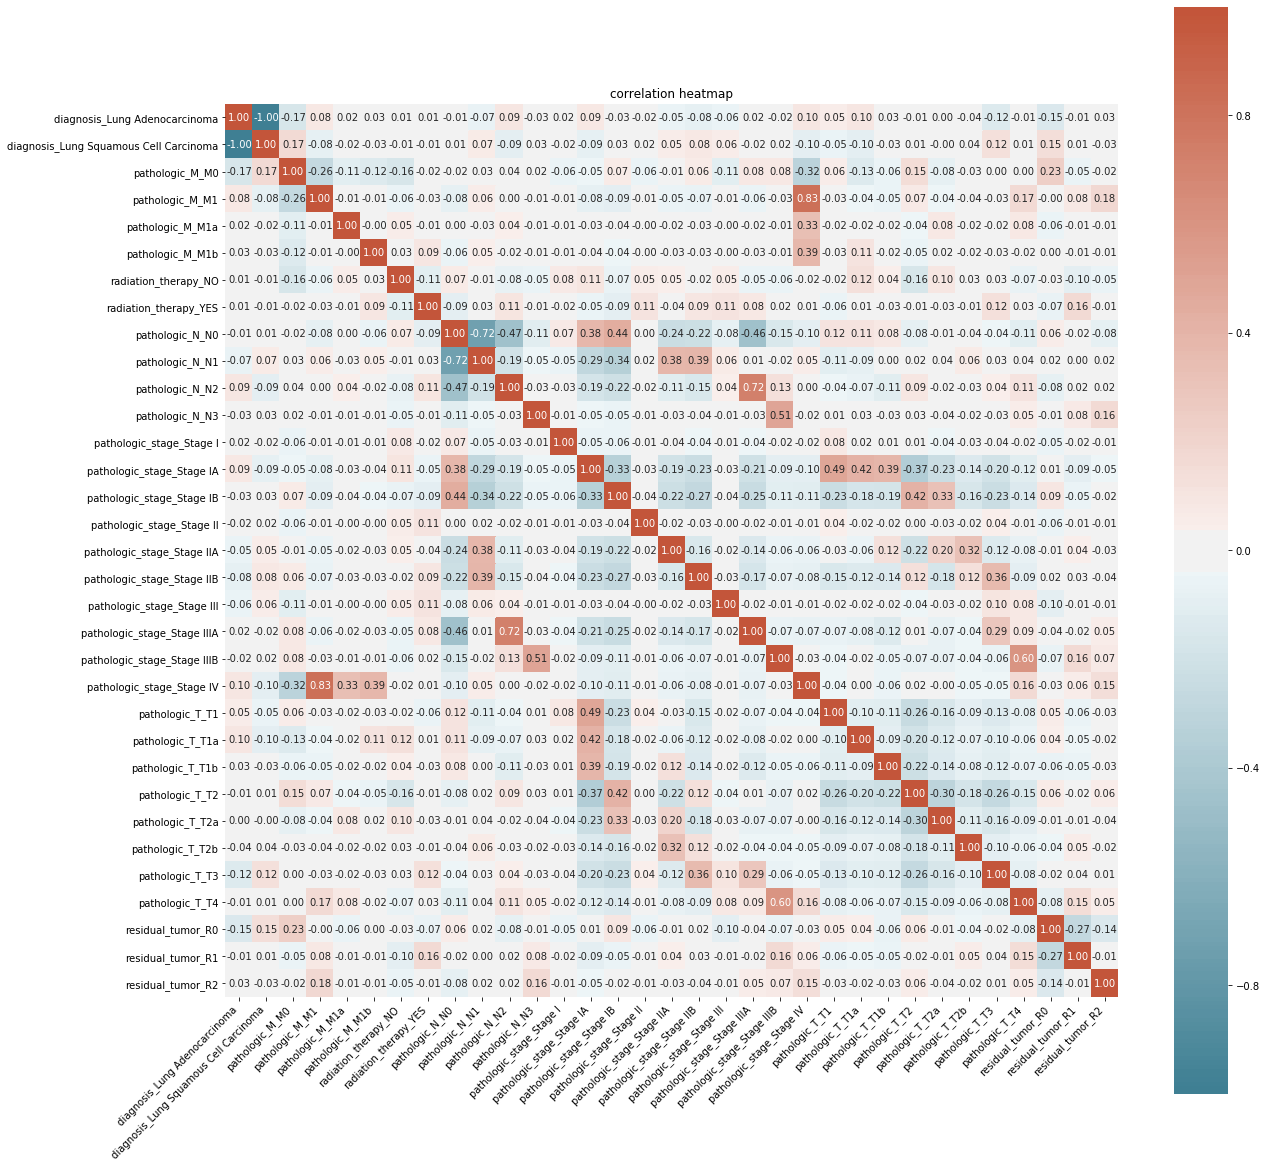

In [0]:
corr_heatmap(x_clin_train, size=(20,20))

In [97]:
x_train = pd.concat([x_clin_train, x_ge_train, x_mut_train], axis=1, sort=True)
x_test = pd.concat([x_clin_test, x_ge_test, x_mut_test], axis=1, sort=True)
score_submission(generate_xgb_model(x_train, x_test), pfs_test)

cv_score: 4.240142199999999


0.4221009147241074

#### 2. group features with too few values

In [105]:
# covert diagnosis
x_clin_train.drop(columns = ["diagnosis_Lung Squamous Cell Carcinoma"], inplace=True)
x_clin_test.drop(columns = ["diagnosis_Lung Squamous Cell Carcinoma"], inplace=True)

# convert residual tumor (group R1 & R2)
x_clin_train["residual_tumor_R1_R2"] = [x+y > 0 for x,y in zip(x_clin_train.residual_tumor_R1.values,x_clin_train.residual_tumor_R2.values)]
x_clin_train.drop(columns = ["residual_tumor_R1", "residual_tumor_R2"], inplace=True)
x_clin_test["residual_tumor_R1_R2"] = [x+y > 0 for x,y in zip(x_clin_test.residual_tumor_R1.values,x_clin_test.residual_tumor_R2.values)]
x_clin_test.drop(columns = ["residual_tumor_R1", "residual_tumor_R2"], inplace=True)

# covert M (group M1, M1a & M1b)
x_clin_train["pathologic_M_M1_M1a_M1b"] = [x+y+z for x,y,z in zip(x_clin_train.pathologic_M_M1.values,x_clin_train.pathologic_M_M1a.values,x_clin_train.pathologic_M_M1b.values)]
x_clin_train.drop(columns = ["pathologic_M_M1", "pathologic_M_M1a",'pathologic_M_M1b'], inplace=True)
x_clin_test["pathologic_M_M1_M1a_M1b"] = [x+y for x,y in zip(x_clin_test.pathologic_M_M1.values,x_clin_test.pathologic_M_M1b.values)]
x_clin_test.drop(columns = ["pathologic_M_M1",'pathologic_M_M1b'], inplace=True)

# covert N (group N1, N2 & N3)
x_clin_train["pathologic_N_N1_N2_N3"] = [x+y+z for x,y,z in zip(x_clin_train.pathologic_N_N1.values,x_clin_train.pathologic_N_N2.values,x_clin_train.pathologic_N_N3.values)]
x_clin_train.drop(columns = ["pathologic_N_N1", "pathologic_N_N2",'pathologic_N_N3'], inplace=True)
x_clin_test["pathologic_N_N1_N2_N3"] = [x+y+z for x,y,z in zip(x_clin_test.pathologic_N_N1.values,x_clin_test.pathologic_N_N2.values,x_clin_test.pathologic_N_N3.values)]
x_clin_test.drop(columns = ["pathologic_N_N1", "pathologic_N_N2",'pathologic_N_N3'], inplace=True)


# covert T
x_clin_train["pathologic_T_T1_T1a_T1b"] = [x+y+z for x,y,z in zip(x_clin_train.pathologic_T_T1.values,x_clin_train.pathologic_T_T1a.values,x_clin_train.pathologic_T_T1b.values)]
x_clin_train.drop(columns = ["pathologic_T_T1", "pathologic_T_T1a",'pathologic_T_T1b'], inplace=True)
x_clin_test["pathologic_T_T1_T1a_T1b"] = [x+y+z for x,y,z in zip(x_clin_test.pathologic_T_T1.values,x_clin_test.pathologic_T_T1a.values,x_clin_test.pathologic_T_T1b.values)]
x_clin_test.drop(columns = ["pathologic_T_T1", "pathologic_T_T1a",'pathologic_T_T1b'], inplace=True)

x_clin_train["pathologic_T_T2_T2a_T2b"] = [x+y+z for x,y,z in zip(x_clin_train.pathologic_T_T2.values,x_clin_train.pathologic_T_T2a.values,x_clin_train.pathologic_T_T2b.values)]
x_clin_train.drop(columns = ["pathologic_T_T2", "pathologic_T_T2a",'pathologic_T_T2b'], inplace=True)
x_clin_test["pathologic_T_T2_T2a_T2b"] = [x+y+z for x,y,z in zip(x_clin_test.pathologic_T_T2.values,x_clin_test.pathologic_T_T2a.values,x_clin_test.pathologic_T_T2b.values)]
x_clin_test.drop(columns = ["pathologic_T_T2", "pathologic_T_T2a",'pathologic_T_T2b'], inplace=True)

x_clin_train["pathologic_T_T3_T4"] = [x+y > 0 for x,y in zip(x_clin_train.pathologic_T_T3.values,x_clin_train.pathologic_T_T4.values)]
x_clin_test["pathologic_T_T3_T4"] = [x+y > 0 for x,y in zip(x_clin_test.pathologic_T_T3.values,x_clin_test.pathologic_T_T4.values)]
x_clin_train.drop(columns = ["pathologic_T_T3", "pathologic_T_T4"], inplace=True)
x_clin_test.drop(columns = ["pathologic_T_T3", "pathologic_T_T4"], inplace=True)
#x_clin_train.drop(columns = ["pathologic_T_T1", "pathologic_T_T1a",'pathologic_T_T1b'], inplace=True)
#x_clin_test.drop(columns = ["pathologic_T_T1", "pathologic_T_T1a",'pathologic_T_T1b'], inplace=True)
#x_clin_train.drop(columns = ["pathologic_T_T2", "pathologic_T_T2a",'pathologic_T_T2b'], inplace=True)
#x_clin_test.drop(columns = ["pathologic_T_T2", "pathologic_T_T2a",'pathologic_T_T2b'], inplace=True)

# convert stage: group IA, IB; then the rest
x_clin_train["pathologic_stage_Stage_IA_IB"] = [x+y+z for x,y,z in zip(x_clin_train['pathologic_stage_Stage I'].values, x_clin_train['pathologic_stage_Stage IA'].values, x_clin_train['pathologic_stage_Stage IB'].values)]
x_clin_train.drop(columns = ['pathologic_stage_Stage I', 'pathologic_stage_Stage IA', 'pathologic_stage_Stage IB'], inplace=True)
x_clin_test["pathologic_stage_Stage_IA_IB"] = [x+y for x,y in zip(x_clin_test['pathologic_stage_Stage IA'].values, x_clin_test['pathologic_stage_Stage IB'].values)]
x_clin_test.drop(columns = ['pathologic_stage_Stage IA', 'pathologic_stage_Stage IB'], inplace=True)

x_clin_train["pathologic_stage_Stage_II_to_IV"] = [x+y+z+a+b+c+d for x,y,z,a,b,c,d in zip(x_clin_train['pathologic_stage_Stage II'].values,x_clin_train['pathologic_stage_Stage IIA'].values, x_clin_train['pathologic_stage_Stage IIB'].values
                                                  , x_clin_train['pathologic_stage_Stage III'].values,x_clin_train['pathologic_stage_Stage IIIA'].values, x_clin_train['pathologic_stage_Stage IIIB'].values, x_clin_train['pathologic_stage_Stage IV'].values)]
x_clin_train.drop(columns = ['pathologic_stage_Stage II', 'pathologic_stage_Stage IIA', 'pathologic_stage_Stage IIB',
                             'pathologic_stage_Stage III', 'pathologic_stage_Stage IIIA', 'pathologic_stage_Stage IIIB',  'pathologic_stage_Stage IV'], inplace=True)
x_clin_test["pathologic_stage_Stage_II_to_IV"] = [x+y+z+a+b for x,y,z,a,b in zip(x_clin_test['pathologic_stage_Stage IIA'].values, x_clin_test['pathologic_stage_Stage IIB'].values
                                                  , x_clin_test['pathologic_stage_Stage IIIA'].values, x_clin_test['pathologic_stage_Stage IIIB'].values, x_clin_test['pathologic_stage_Stage IV'].values)]
x_clin_test.drop(columns = ['pathologic_stage_Stage IIA', 'pathologic_stage_Stage IIB',
                            'pathologic_stage_Stage IIIA', 'pathologic_stage_Stage IIIB',  'pathologic_stage_Stage IV'], inplace=True)

x_clin_test.head(2)

,diagnosis_Lung Adenocarcinoma,pathologic_M_M0,radiation_therapy_NO,radiation_therapy_YES,pathologic_N_N0,pathologic_stage_Stage II,residual_tumor_R0,age_at_initial_pathologic_diagnosis,number_pack_years_smoked,residual_tumor_R1_R2,pathologic_M_M1_M1a_M1b,pathologic_N_N1_N2_N3,pathologic_T_T1_T1a_T1b,pathologic_T_T2_T2a_T2b,pathologic_T_T3_T4,pathologic_stage_Stage_IA_IB,pathologic_stage_Stage_II_to_IV
patient_id,,,,,,,,,,,,,,,,,
TEST_0000,1,1,0,0,1,0,1,70.0,43,False,0,0,1,0,False,1,0
TEST_0001,1,1,0,0,1,0,1,58.0,15,False,0,0,0,1,False,1,0


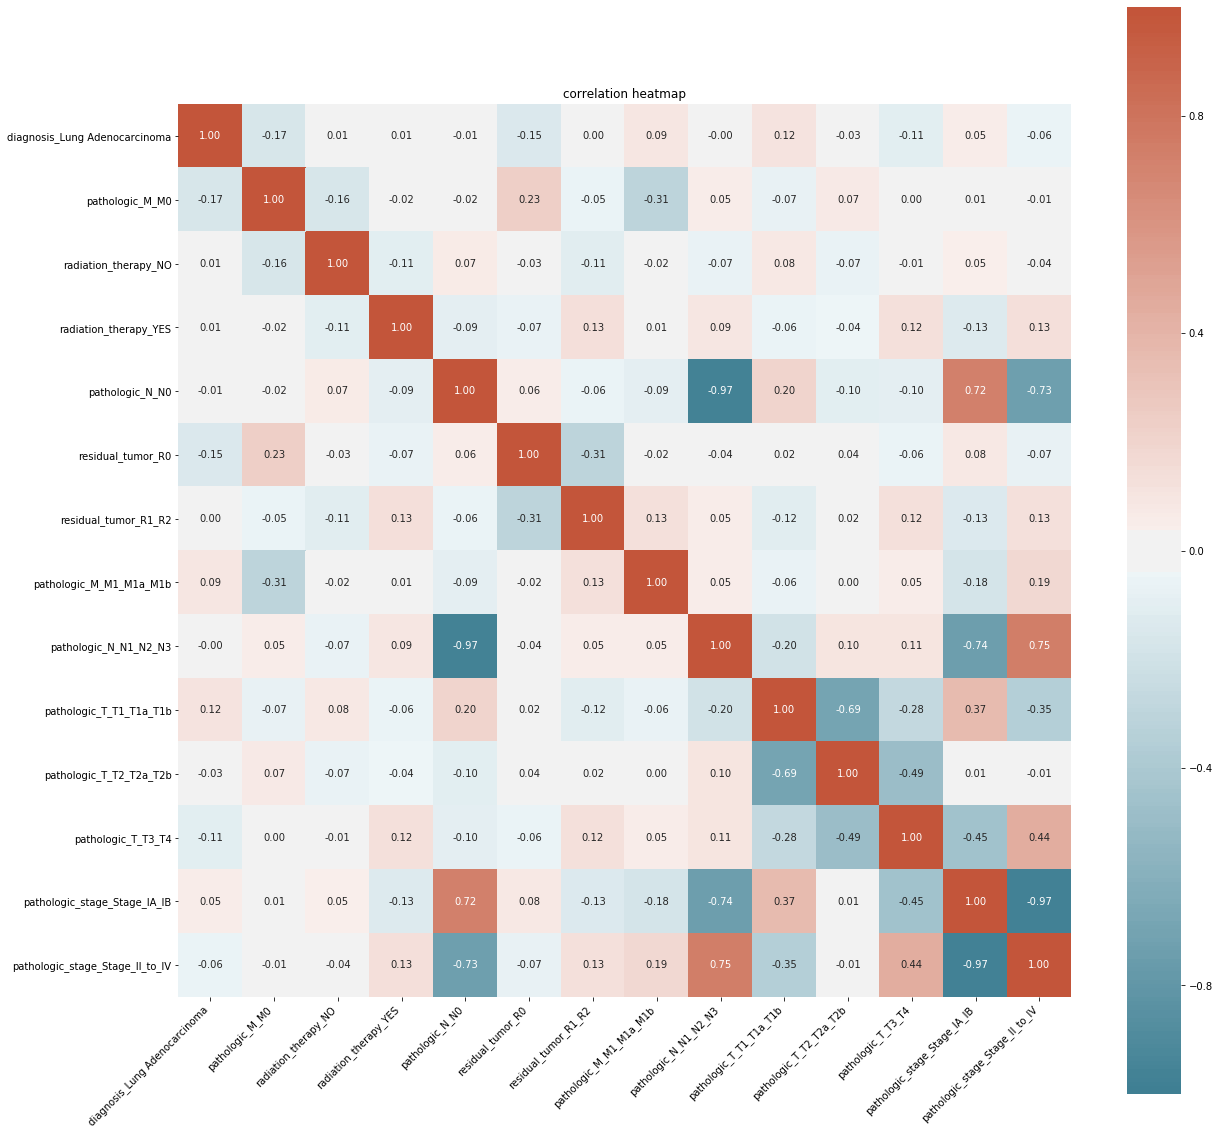

In [0]:
corr_heatmap(x_clin_train, size=(20,20))

In [94]:
x_train = pd.concat([x_clin_train, x_ge_train], axis=1, sort=True) #, x_mut_train
x_test = pd.concat([x_clin_test, x_ge_test], axis=1, sort=True) #, x_mut_train
score_submission(generate_xgb_model(x_train, x_test), pfs_test)

cv_score: 4.235287


0.4367069932133373

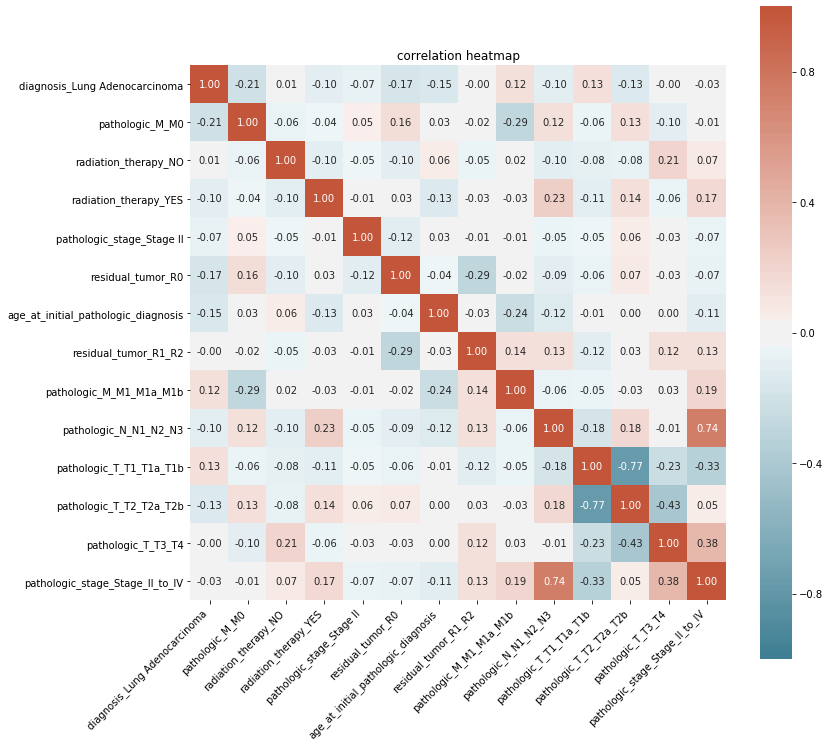

In [106]:
x_clin_train.drop(columns = [ "pathologic_N_N0", "pathologic_stage_Stage_IA_IB"], inplace=True) #, 'radiation_therapy_YES', "pathologic_T_T3_T4","pathologic_T_T1_T1a_T1b","pathologic_M_M0","pathologic_N_N0",, "pathologic_T_T3_T4","pathologic_T_T1_T1a_T1b", "pathologic_T_T3_T4"
x_clin_test.drop(columns =  ["pathologic_N_N0", "pathologic_stage_Stage_IA_IB"], inplace=True) #, "pathologic_stage_Stage_IA_IB","pathologic_T_T1_T1a_T1b", ["pathologic_N_N0",
corr_heatmap(x_clin_test, size=(12,12))

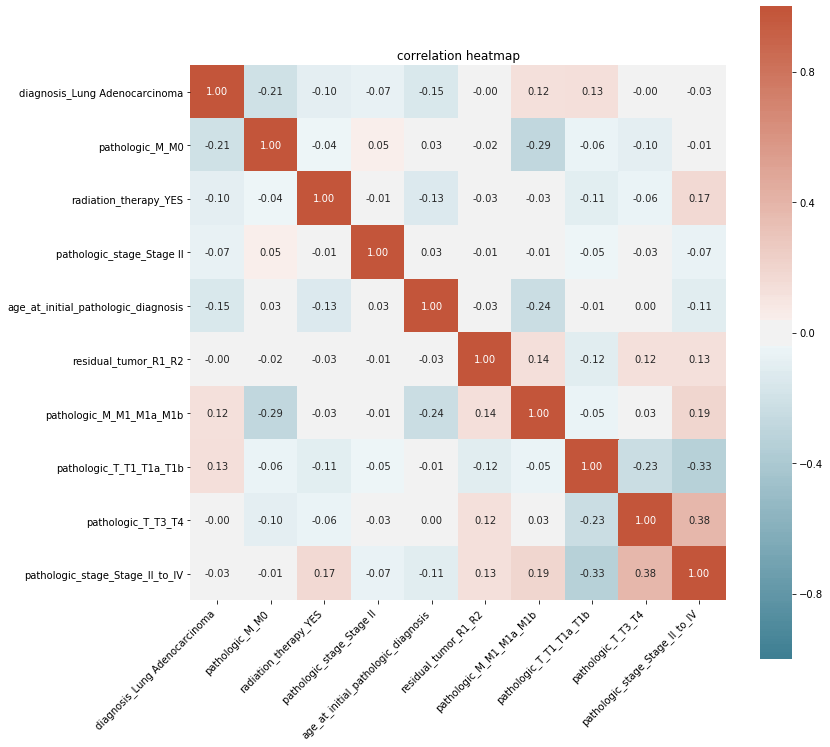

In [107]:
x_clin_train.drop(columns = ['radiation_therapy_NO', 'residual_tumor_R0', "pathologic_T_T2_T2a_T2b", "pathologic_N_N1_N2_N3"], inplace=True) #, 'radiation_therapy_YES', "pathologic_T_T3_T4","pathologic_T_T1_T1a_T1b","pathologic_M_M0","pathologic_N_N0",, "pathologic_T_T3_T4","pathologic_T_T1_T1a_T1b", "pathologic_T_T3_T4"
x_clin_test.drop(columns =  ['radiation_therapy_NO', 'residual_tumor_R0', "pathologic_T_T2_T2a_T2b", "pathologic_N_N1_N2_N3"], inplace=True) #, "pathologic_stage_Stage_IA_IB","pathologic_T_T1_T1a_T1b", ["pathologic_N_N0",
corr_heatmap(x_clin_test, size=(12,12))

In [108]:
x_train = pd.concat([x_clin_train, x_ge_train, x_mut_train], axis=1, sort=True)
x_test = pd.concat([x_clin_test, x_ge_test, x_mut_test], axis=1, sort=True)
score_submission(generate_xgb_model(x_train, x_test), pfs_test)

cv_score: 4.231501


0.43744467394511655

## RNA-seq data cleaning

### 4. Find co-expression geneset by pearson correlation

In [109]:
cidx_df.sort_values('dev_from_random', ascending=False, inplace=True)
cidx_df.head()

,gene,cidx,dev_from_random
29893,SESN3,0.614928,0.114928
32863,TESK2,0.606131,0.106131
19872,NTRK2,0.604501,0.104501
30749,SMARCA1,0.397744,0.102256
8276,FMO4,0.601611,0.101611


In [0]:
ge_train = ge_train.transpose()
ge_test = ge_test.transpose()

In [111]:
cidx_top = cidx_df.iloc[:100]
protective_genes = list(cidx_top[cidx_top.cidx<0.5].gene.values)
inducing_genes = list(cidx_top[cidx_top.cidx>0.5].gene.values)
print(len(protective_genes))
print(len(inducing_genes))

33
67


In [0]:
import scipy
# analyze genes with top100 cidx
pearson_set1={}
genes = protective_genes

In [0]:
for i in range(len(genes)):
    for j in range(i+1,len(genes)):
        x = list(ge_test.loc[:,genes[i]])
        y = list(ge_test.loc[:,genes[j]])
        r,p =scipy.stats.pearsonr(x,y)
        if r >= 0.7 and p < 0.05:
            if genes[i] in pearson_set1 or genes[j] in pearson_set1:
                pearson_set1.add(genes[i])
                pearson_set1.add(genes[j])
            elif genes[i] in pearson_set2 or genes[j] in pearson_set2:
                pearson_set2.add(genes[i])
                pearson_set2.add(genes[j])
            else: # neither gene in existed set
                print(genes[i], genes[j], r)

In [0]:
induce_set1 = {'NTRK2', 'DAPL1'}#{'FOXE1', 'DAPL1', 'ADH7', 'CSTA'}
genes = inducing_genes

In [0]:
for i in range(len(genes)):
    for j in range(i+1,len(genes)):
        x = list(ge_test.loc[:,genes[i]])
        y = list(ge_test.loc[:,genes[j]])
        r,p =scipy.stats.pearsonr(x,y)
        if abs(r) >= 0.75 and p < 0.05:
            if genes[i] in induce_set1 or genes[j] in induce_set1:
                induce_set1.add(genes[i])
                induce_set1.add(genes[j])
            else: # neither gene in existed set
                print(genes[i], genes[j], r)

In [127]:
induce_set1 = list(induce_set1)
induce_set2=['PCDHA2', 'PCDHA3']
print(induce_set1)

['KRT42P', 'NTRK2', 'MIR205HG', 'OR7E28P', 'ADH7', 'DENND2C', 'CSTA', 'SERPINB13', 'GRHL3', 'STARD5', 'DAPL1']


In [0]:
ge_train['induce_set1'] = ge_train[induce_set1].mean(axis=1) # add a column to ge_train
ge_test['induce_set1'] = ge_test[induce_set1].mean(axis=1) # add a column to ge_test
ge_train['induce_set2'] = ge_train[induce_set2].mean(axis=1) # add a column to ge_train
ge_test['induce_set2'] = ge_test[induce_set2].mean(axis=1) # add a column to ge_test

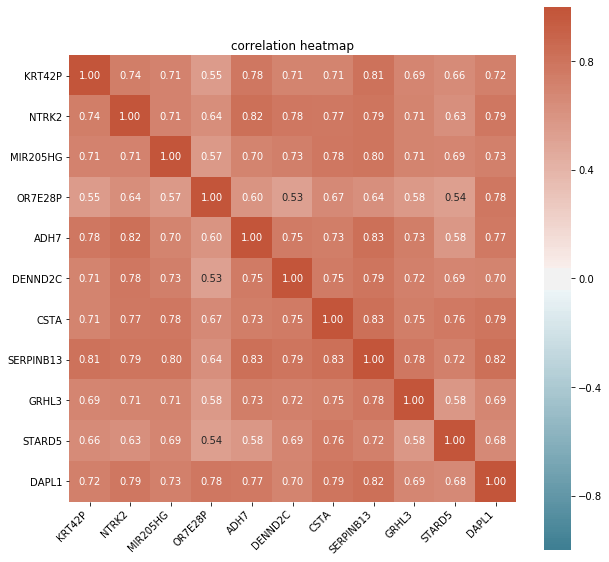

In [129]:
corr_heatmap(ge_test[induce_set1],size=(10,10))

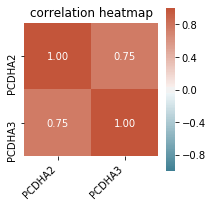

In [131]:
corr_heatmap(ge_test[induce_set2],size=(3,3))

In [132]:
# Group co-expressed genes into one feature and delete individual genes from ge_train & ge_test
for gene in induce_set1:
    inducing_genes.remove(gene)
print(len(inducing_genes))
print(len(protective_genes))

56
33


Test performance

In [133]:
a = list(inducing_genes)
a.extend(protective_genes)
a.append('induce_set1')
x_ge_train = ge_train[a]
x_ge_test = ge_test[a]
x_ge_train.head()

,SESN3,TESK2,FMO4,FGFR2,HLF,RGMA,KRT15,CYP2S1,SEMA4A,CD9,DBP,GSTM2,ATP13A5,ITGA9-AS1,SDR42E1,STAR,FMO6P,PRSS12,TEF,ST6GALNAC2,CLDN16,INSYN1-AS1,CERS3-AS1,LINC02598,PTPRZ1,GVQW2,NPPC,CTTNBP2,WNT2B,FAM117A,JPH1,WSCD2,SLC52A1,APOBEC3C,CBX7,BCL11A,ASTE1,SUSD4,TRPV4,COLCA1,...,SYNPR-AS1,LNCTAM34A,SLC1A4,NTF4,KLRG2,LINC00240,SMARCA1,AKAP12,LINC00862,TUBB3,UGGT2,GOLM1,STRIP2,NKILA,PCDHA13,HTR1D,ITGB1-DT,PNMA1,LINC00346,ADAMTS6,FAM83A-AS1,BLOC1S4,TP53I3,VAV2,PLEKHG2,DNAJC10,IBTK,FUBP1,RHOF,ABL2,TM9SF1,LRP10,HARS2,PCDHA2,FAM222B,PVR,PCDHA3,PCDHA5,BZW1,induce_set1
TRAIN_0001,7.6986,2.7103,2.5635,4.7445,5.8091,3.6904,6.9574,4.4667,5.2575,7.3454,4.3726,3.7394,0.1396,0.8189,5.0105,-2.8699,-2.7255,6.1695,5.3249,2.6685,0.9211,-7.1178,-7.1178,-7.1178,-1.3899,-2.3629,-4.7959,0.2131,2.7167,4.8476,2.5529,-0.4596,1.7981,5.4814,4.7390,4.1425,3.0230,4.2708,2.9060,3.8616,...,0.1583,-1.6259,5.6315,0.0012,3.2756,0.2831,4.8155,3.2496,-4.3104,3.7533,4.3585,9.3852,0.6701,0.3821,-0.4884,-3.0303,-3.4173,4.4611,2.0696,-0.9280,2.0294,3.2365,3.9191,6.1564,4.8163,6.8538,6.4015,6.6967,1.4330,5.9072,3.2670,8.2852,4.6599,-0.4596,6.0084,5.2532,-0.9680,-2.2598,7.3543,-1.453682
TRAIN_0002,5.7339,1.9924,1.6926,2.4437,6.1519,0.9721,4.6508,5.2920,5.0178,7.8213,3.0025,2.4934,-4.1689,-0.4684,4.1665,-3.2758,-3.5168,2.0817,4.5081,5.0664,-1.8470,-6.9762,-5.3913,-4.6543,1.8279,-2.5839,-4.1689,1.2185,0.1218,4.2447,2.2012,-3.0694,0.6458,6.3836,3.9026,1.2086,3.2320,1.1582,1.7753,-0.6364,...,-0.7864,-1.6187,4.4990,0.6748,1.4873,-1.7668,6.6989,4.8696,-2.8888,5.2529,4.1211,8.3084,4.1639,4.2520,-1.3615,3.7845,2.9823,6.1302,3.9314,0.9003,3.0336,4.7940,6.2048,5.9857,6.8538,7.4083,5.8321,6.6836,3.4677,5.9632,3.4719,8.4670,5.1365,-2.7283,6.4135,7.7549,-1.6908,-3.2758,7.8156,-0.907718
TRAIN_0003,4.6815,3.0889,1.8261,5.1153,1.6026,4.3729,6.5928,5.6967,5.7528,9.4865,4.2412,3.8794,-2.3043,1.0139,4.1198,-4.7823,-5.2678,3.4513,5.1188,3.5024,0.0614,-6.0047,-7.5897,-0.4298,3.4040,-1.0819,-5.2678,-0.2410,1.9630,3.9027,1.0933,2.4938,2.8355,6.3500,4.7353,1.0863,3.3492,3.9730,4.3385,2.9446,...,-7.5897,-0.6472,5.6714,1.3847,0.2241,-0.1385,5.5111,4.2841,1.3082,3.1064,5.3453,8.9082,0.8820,0.6911,-3.1974,1.9436,-0.9603,6.0168,2.5588,1.0721,0.0898,4.1446,4.5887,6.1373,5.0616,7.9030,5.6456,6.7921,2.8972,5.4903,3.2472,8.1029,5.1192,0.7897,5.7760,6.3064,1.8048,2.2605,7.0397,-1.311045
TRAIN_0004,5.6656,2.4480,2.3102,3.9597,3.7342,1.8263,5.2524,3.4112,5.8313,8.8594,2.4480,4.1354,0.5385,1.3216,4.2823,-3.9339,-3.9339,4.5181,4.2025,3.6037,-0.9705,-6.2559,-4.6709,-4.6709,-0.8296,-2.0079,-6.2559,1.4095,2.4480,4.1461,4.3598,-0.4230,-0.8296,5.1033,5.1509,1.9873,3.1386,4.4350,1.6689,3.0365,...,0.9240,1.0570,4.4506,1.0203,1.4788,0.4584,7.1710,4.7049,1.8786,3.3272,3.7734,6.8181,1.4095,2.1148,1.5707,0.0479,-3.4485,4.3244,1.5057,0.0109,0.8837,3.9789,5.8293,5.3676,6.7112,6.2497,6.4795,6.6350,2.9705,5.5462,2.7581,8.3404,5.3739,-3.4485,5.4407,5.1751,-0.8983,-1.8636,7.5407,-0.976918
TRAIN_0005,6.8155,2.6298,2.8998,3.4409,3.5129,-0.1034,0.6029,1.3398,6.6680,8.1921,3.2411,0.6029,-1.4127,0.4731,-0.1549,-4.3513,-4.3513,4.4805,3.8823,0.7502,-2.2359,-5.9363,-5.9363,-4.3513,2.5833,-2.4769,-5.9363,2.4858,1.4646,3.2511,1.1190,-1.0783,-3.6144,3.7899,4.3526,3.7449,3.0091,4.5056,-0.1549,4.6458,...,2.0003,-2.0294,4.8094,-0.4444,-4.3513,0.0410,6.3960,4.8654,-2.0294,2.9796,5.0157,10.3767,4.5364,-0.9821,-3.6144,-2.0294,-2.7664,4.2695,2.2386,0.8839,1.7572,4.2671,4.4994,7.0487,6.6016,7.8462,7.5481,6.6079,2.2877,4.7103,3.2949,7.9470,4.2424,-1.2924,5.7304,4.4742,-0.2084,-3.6144,7.9028,-2.641736


In [134]:
x_train = pd.concat([x_clin_train, x_ge_train, x_mut_train], axis=1, sort=True)
x_test = pd.concat([x_clin_test, x_ge_test, x_mut_test], axis=1, sort=True)
score_submission(generate_xgb_model(x_train, x_test), pfs_test)

cv_score: 4.2277932


0.4336087341398643

### Non-linear Cox Model

In [0]:
from pysurvival.models.semi_parametric import NonLinearCoxPHModel
from pysurvival.utils.metrics import concordance_index
from pysurvival.utils.display import integrated_brier_score
from sklearn.model_selection import train_test_split

# Building training and testing sets #
index_train, index_test = train_test_split(range(x_train.shape[0]), test_size = 0.2)
data_train = x_train_imp.iloc[index_train].reset_index( drop = True )
data_test  = x_train_imp.iloc[index_test].reset_index( drop = True )

X_train, X_test = data_train, data_test
T_train, T_test = pfs_train.iloc[index_train].time_to_progression_or_censor.values, pfs_train.iloc[index_test].time_to_progression_or_censor.values
E_train, E_test = pfs_train.iloc[index_train].progression.values, pfs_train.iloc[index_test].progression.values
structure = [ {'activation': 'SELU', 'num_units': 150},  ]

C-index: 0.57


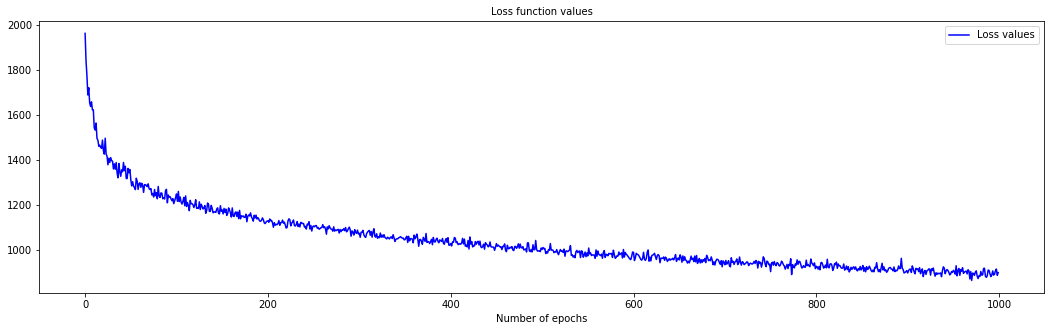

In [0]:
# Building the model
nonlinear_coxph = NonLinearCoxPHModel(structure=structure)
nonlinear_coxph.fit(X_train, T_train, E_train, lr=1e-3, init_method='glorot_uniform', num_epochs=1000, optimizer='adam', l2_reg=1e-03,dropout=0.5)


c_index = concordance_index(nonlinear_coxph, X_test, T_test, E_test) #0.81
print('C-index: {:.2f}'.format(c_index))

from pysurvival.utils.display import display_loss_values
# We can now display the loss function values in respect to the epochs
display_loss_values(nonlinear_coxph)

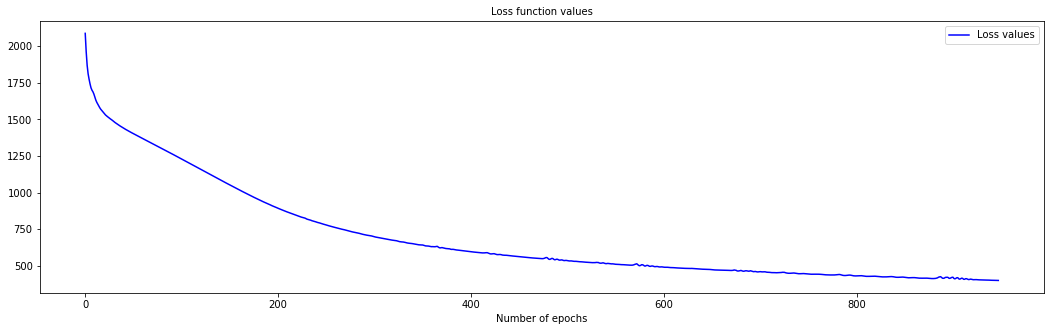

0.42844496901740925

In [177]:
structure = [ {'activation': 'SELU', 'num_units': 150},  ]

nonlinear_coxph = NonLinearCoxPHModel(structure=structure)
nonlinear_coxph.fit(x_train_imp, pfs_train.time_to_progression_or_censor.values, pfs_train.progression.values,
                    lr=1e-3, init_method='glorot_uniform', num_epochs=1000, optimizer='adam', l2_reg=0.1
                    ,dropout=0)

from pysurvival.utils.display import display_loss_values
# We can now display the loss function values in respect to the epochs
display_loss_values(nonlinear_coxph)

pred_deepsuv = nonlinear_coxph.predict_risk(x_test_imp)
pred_deepsuv_df = pd.DataFrame({
    "patient_id": x_test_imp.index.values,
    "risk_score": pred_deepsuv
})
score_submission(pred_deepsuv_df, pfs_test)